In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from IPython.display import display
from tab_hero.dataio.tokenizer import ChartTokenizer

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
from sklearn.metrics import adjusted_rand_score
from itertools import product
from scipy.stats import spearmanr
from sklearn.feature_selection import f_classif

import random

In [2]:
def clean_df(df: pd.DataFrame, cols, extra_cols=None) -> pd.DataFrame:
    """Select columns, replace inf with NaN, drop rows with missing values."""
    cols = list(cols)
    if extra_cols:
        cols = list(dict.fromkeys(list(extra_cols) + cols))
    return df[cols].replace([np.inf, -np.inf], np.nan).dropna()

def standardize(X):
    """Z-score standardize features."""
    return StandardScaler().fit_transform(X)

def kmeans_labels(scaled, k, random_state=0, n_init=10):
    """KMeans labels for standardized data."""
    return KMeans(n_clusters=k, random_state=random_state, n_init=n_init).fit_predict(scaled)

def silhouette_over_k(scaled, ks, random_state=0, n_init=10):
    """Silhouette sweep for KMeans over a list or range of k."""
    sil = []
    for k in ks:
        labels = kmeans_labels(scaled, k, random_state=random_state, n_init=n_init)
        sil.append(silhouette_score(scaled, labels))
    return sil

def plot_silhouette_curve(ks, sil, title, xlabel="k", ylabel="silhouette", marker="o"):
    plt.plot(list(ks), sil, marker=marker)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def pca2(scaled, n_components=2, random_state=0):
    return PCA(n_components=n_components, random_state=random_state).fit_transform(scaled)

def plot_pca_clusters(Z, labels, title, s=6, cbar_label="cluster"):
    plt.scatter(Z[:, 0], Z[:, 1], c=labels, s=s)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.colorbar(label=cbar_label)
    plt.tight_layout()
    plt.show()

def plot_heatmap(M, xlabels, ylabels, title, cbar_label=None, figsize=(6,5), aspect="auto"):
    plt.figure(figsize=figsize)
    plt.imshow(M, aspect=aspect)
    plt.xticks(range(len(xlabels)), [str(x) for x in xlabels], rotation=0)
    plt.yticks(range(len(ylabels)), [str(y) for y in ylabels])
    if cbar_label:
        plt.colorbar(label=cbar_label)
    else:
        plt.colorbar()
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_bar(categories, values, title, xlabel=None, ylabel=None, rotate=90, figsize=None):
    if figsize:
        plt.figure(figsize=figsize)
    plt.bar([str(c) for c in categories], values)
    if rotate:
        plt.xticks(rotation=rotate)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def cluster_labels(cols):
    X = df_features[cols].replace([np.inf, -np.inf], np.nan).dropna()
    scaled = standardize(X.values)
    return KMeans(n_clusters=8, random_state=0, n_init=10).fit_predict(scaled)

def bootstrap_std(x, n=30, frac=0.8):
    rng = np.random.default_rng(0)
    vals = []
    for _ in range(n):
        idx = rng.choice(len(x), size=int(frac * len(x)), replace=True)
        vals.append(np.nanmean(x[idx]))
    return float(np.std(vals))


In [3]:
project_root = Path.cwd()
sys.path.insert(0, str(project_root / "src"))

from tab_hero.dataio.tab_format import load_tab
data_dir = Path("../data/processed") 
tab_files = list(data_dir.glob("*.tab"))
SEED = 42

In [4]:
features_path = Path("../features.csv")

df_features = pd.read_csv(features_path)
df_features.head()


,content_hash,difficulty_id,instrument_id,genre_id,song_id,duration_sec,rms_energy_mean,rms_energy_std,amplitude_envelope_min,amplitude_envelope_max,...,inter_note_ms_std,inter_note_ms_median,inter_note_ms_p25,inter_note_ms_p75,sustain_ratio,chord_ratio,fret_entropy,hopo_ratio,star_power_ratio,tap_ratio
0,00068c50bf7a2a95,0,2,7,3631,163.480091,1.891090,1.430148,0.402069,4.052784,...,742.686223,830.0,820.0,830.0,0.041667,0.000000,1.107923,0.000000,0.104167,0.000000
1,00044d42d97be12d,0,2,4,1694,194.292971,1.687803,0.795066,0.098820,2.682918,...,564.478392,1060.0,1050.0,1085.0,0.378378,0.000000,0.986289,0.000000,0.189189,0.000000
2,0005aa02866dddf6,0,2,1,2663,313.620317,1.692548,0.409827,0.087721,2.114662,...,473.929208,730.0,720.0,740.0,0.075269,0.000000,1.488865,0.997312,0.169355,0.000000
3,0003cad26b028e39,1,0,1,1470,285.826032,1.766457,0.513506,0.056087,2.944388,...,415.654713,360.0,240.0,490.0,0.356021,0.031414,1.367438,0.942408,0.116928,0.057592
4,0005cc1d3cbc5253,2,1,3,340,247.118367,3.104284,1.243821,0.271522,6.126035,...,580.585199,250.0,250.0,510.0,0.111905,0.690476,1.583723,0.990476,0.119048,0.002381


In [5]:
tab_files = sorted(tab_files)
random.seed(SEED)
sample_files = random.sample(tab_files, k=300)

In [6]:
rows = []
errors = []

for p in sample_files:
    try:
        data = load_tab(p)
        row = dict(data.__dict__)
        rows.append(row)
    except Exception as e:
        
        errors.append((p.name, str(e)))


In [7]:
df_tabs = pd.DataFrame(rows)
df_tabs.head()

,mel_spectrogram,sample_rate,hop_length,note_tokens,difficulty_id,instrument_id,content_hash,genre_id,song_id
0,"[[-1.1279297, -1.1279297, -1.1279297, -1.12792...",22050,256,"[1, 503, 518, 631, 642, 70, 518, 631, 642, 70,...",2,0,c940117355a8f420,1,6052
1,"[[-2.8808594, -2.9042969, -3.0117188, -3.13281...",22050,256,"[1, 503, 505, 631, 640, 35, 505, 631, 640, 35,...",2,0,237b10b35cabd811,1,472
2,"[[-2.2167969, -2.2167969, -2.2167969, -2.21679...",22050,256,"[1, 440, 504, 631, 642, 36, 505, 631, 642, 36,...",2,0,07e1e41e1003f1b1,13,5934
3,"[[-2.6796875, -2.6796875, -2.6796875, -2.67968...",22050,256,"[1, 503, 504, 632, 653, 77, 504, 632, 639, 40,...",1,2,e924eea23ea77a15,7,370
4,"[[-2.6230469, -2.6230469, -2.6230469, -2.62304...",22050,256,"[1, 393, 504, 631, 642, 84, 505, 631, 642, 51,...",1,2,563cfff61d1a085a,1,3592


<h1>1. Difficulty analysis </h1>

C:\Users\Susan\AppData\Local\Temp\ipykernel_44972\1336585083.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=[str(d) for d in diffs], showfliers=False)


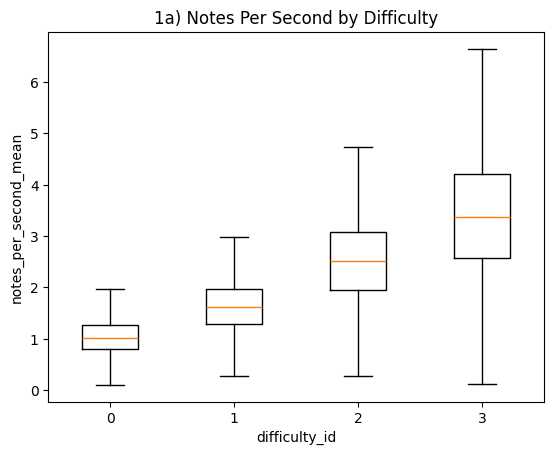

C:\Users\Susan\AppData\Local\Temp\ipykernel_44972\1336585083.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=[str(d) for d in diffs], showfliers=False)


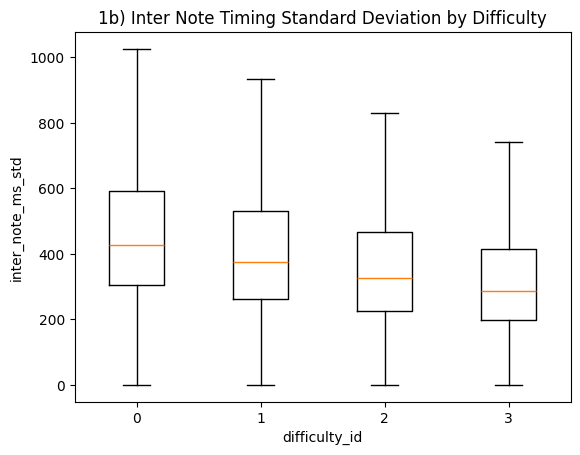

In [8]:
def plot_box_by_difficulty(df, y_col, title):
    diffs = sorted(df["difficulty_id"].dropna().unique())
    groups = [df.loc[df["difficulty_id"] == d, y_col].dropna() for d in diffs]
    plt.boxplot(groups, labels=[str(d) for d in diffs], showfliers=False)
    plt.xlabel("difficulty_id")
    plt.ylabel(y_col)
    plt.title(title)
    plt.show()


plot_box_by_difficulty(df_features, "notes_per_second_mean", "1a) Notes Per Second by Difficulty")
plot_box_by_difficulty(df_features, "inter_note_ms_std", "1b) Inter Note Timing Standard Deviation by Difficulty")


The following analysis confirms the assumption that the higher the difficulty, the faster the notes appear. The box plots confirm this with higher difficulties showing a higher notes_per_second_mean and a lower inter_note_ms_std. Interestingly enough, the higher difficulties have more variable notes_per_second_means. This likely reflects the fact that the notes in higher difficulties tend to more accurately reflect the notes of the song. As difficulties get lower, the note order needs to be summarized to appear at an easier pace while still capturing the pattern of the song being played.

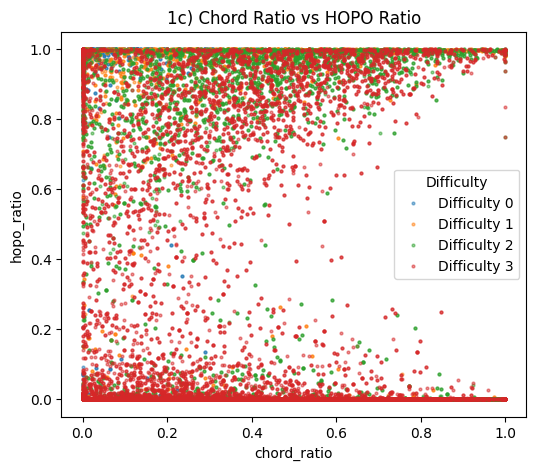

In [9]:
difficulty_levels = sorted(df_features["difficulty_id"].dropna().unique())

plt.figure(figsize=(6, 5))

for d in difficulty_levels:
    mask = (
        df_features["chord_ratio"].notna() &
        df_features["hopo_ratio"].notna() &
        (df_features["difficulty_id"] == d)
    )

    plt.scatter(
        df_features.loc[mask, "chord_ratio"],
        df_features.loc[mask, "hopo_ratio"],
        s=4,
        alpha=0.5,
        label=f"Difficulty {d}"
    )

plt.xlabel("chord_ratio")
plt.ylabel("hopo_ratio")
plt.title("1c) Chord Ratio vs HOPO Ratio")
plt.legend(title="Difficulty")
plt.show()

The Chord Ratio vs HOPO Ratio aims to compare how mechanical structure evolves with difficulty and whether difficulty reflects different stylistic meanings. The results appear generally noisy, but a few trends can be extgracted. Many of the charts concentrate at 0 or 1 for HOPO with very sparse points in between. This indicates that charts are either heavily HOPO based or hardly use it at all. Regions with boderate to high Chord vs HOPO ratios skew towards higher difficulty levels. 

<h1>2. Instrument Analysis</h1>

In [10]:
instrument_names = {
    0: "Lead",
    1: "Bass",
    2: "Rythm",
    3: "Keys",
}

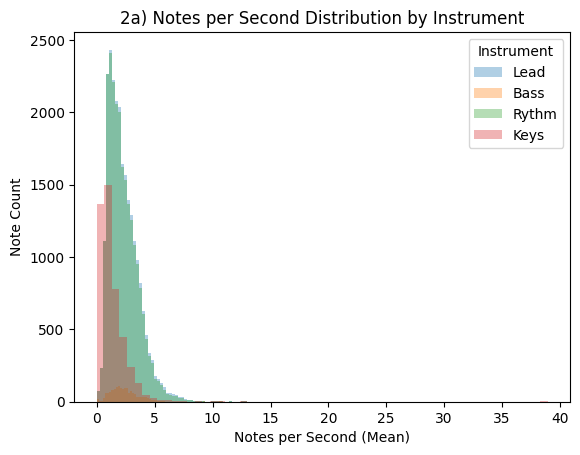

In [11]:
insts = sorted(df_features["instrument_id"].dropna().unique())

for inst in insts:
    vals = df_features.loc[
        df_features["instrument_id"] == inst,
        "notes_per_second_mean"
    ].dropna()

    plt.hist(
        vals,
        bins=60,
        alpha=0.35,
        label=instrument_names.get(inst, str(inst))
    )

plt.xlabel("Notes per Second (Mean)")
plt.ylabel("Note Count")
plt.title("2a) Notes per Second Distribution by Instrument")
plt.legend(title="Instrument")
plt.show()

This histogram reveals that Lead and Rhythm charts generally have higher notes per second than Bass and Keys. Bass charts tend to concentrate at lower densities, suggesting simpler rhythmic structures while Lead and Rhythm are much denser, indicating more complicated patterns. It reveals that note density is instrument dependent and provides a strong signal for modeling instrument specific chart behavior.

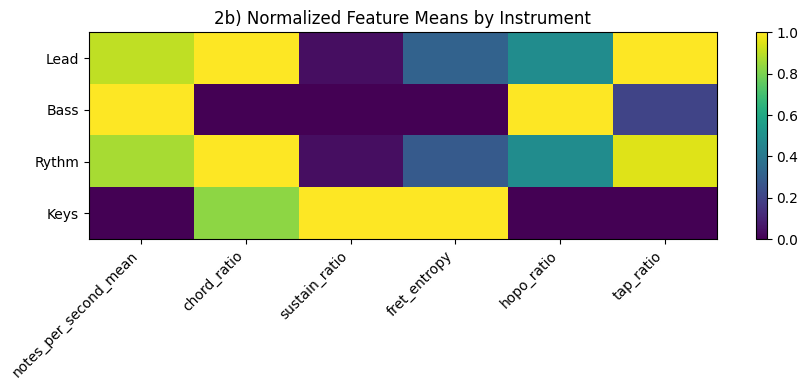

In [12]:
cols = ["notes_per_second_mean", "chord_ratio", "sustain_ratio", "fret_entropy", "hopo_ratio", "tap_ratio"]
means = df_features.groupby("instrument_id")[cols].mean().sort_index()
norm = (means - means.min()) / (means.max() - means.min())



plt.figure(figsize=(9, 4))
plt.imshow(norm.values, aspect="auto")

plt.yticks(
    range(len(norm.index)),
    [instrument_names.get(i, str(i)) for i in norm.index]
)

plt.xticks(range(len(cols)), cols, rotation=45, ha="right")
plt.colorbar()
plt.title("2b) Normalized Feature Means by Instrument")
plt.tight_layout()
plt.show()

Lead and Rhythm have higher note density, chord ratio, HOPO ratio, and tap ratio, reinforcing the idea that these instruments contain complex and varied patterns. Bass exhibits high note density but very low chord, sustain, and HOPO ratios, suggesting simpler, more repetitive structures focused on single note lines. Keys stand out with very high sustain ratio and fret entropy but low HOPO and tap usage, implying longer held notes and more evenly distributed fret usage rather than fast technical passages. Overall, instruments have distinct structural signatures in feature space, confirming that instrument conditioning is important for modeling and generation.

<h1>3. Density Profiling</h1>

In [13]:
def time_bins_from_tokens(tokens, tokenizer):
    toks = np.array(tokens, dtype=np.int32)
    time_mask = (toks >= tokenizer._time_token_start) & (toks < tokenizer._time_token_end)
    return (toks[time_mask] - tokenizer._time_token_start).astype(np.int32)

def rolling_density(time_bins, window=80):
    if len(time_bins) == 0:
        return np.array([])
    inv = 1.0 / np.clip(np.array(time_bins, dtype=np.float32), 1e-6, None)
    if inv.size < window:
        window = inv.size
    return np.convolve(inv, np.ones(window) / window, mode="valid")


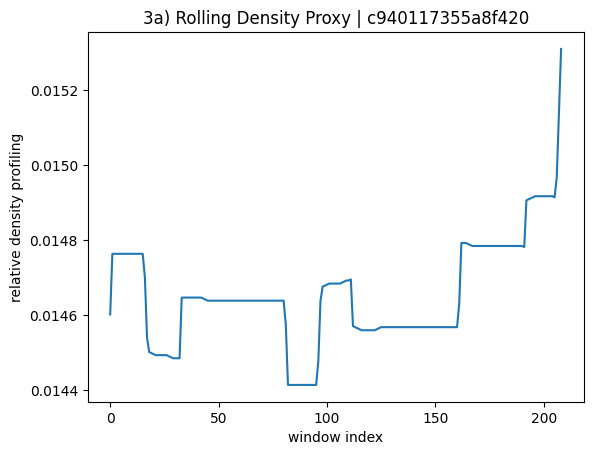

In [14]:
tokenizer = ChartTokenizer()

r = df_tabs.iloc[0]
tb = time_bins_from_tokens(r["note_tokens"], tokenizer)
rd = rolling_density(tb, window=80)

plt.plot(rd)
plt.xlabel("window index")
plt.ylabel("relative density profiling")
plt.title(f"3a) Rolling Density Proxy | {r.get('content_hash','')}")
plt.show()

The rolling density proxy shows relativey stable note densite throughout most of the chart, with small localized dips and gradual increases. The sensity slightly decreases in early and midsections then trends upwards towards then end, indicating a ramp-up in the later half of the track. Ovearll, the chart appears rhythmically consistent with modest structural variation rather than dramatic burst sections.

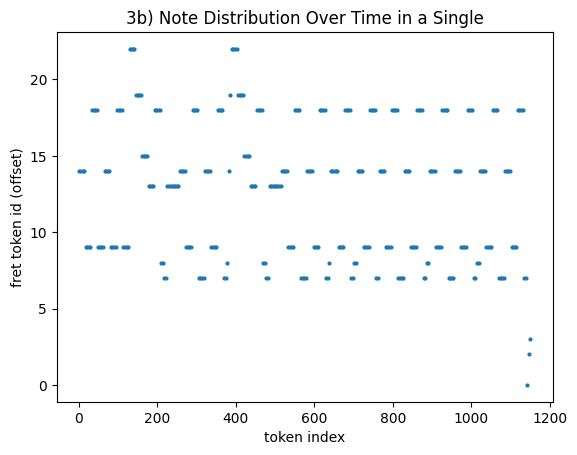

In [15]:
r = df_tabs.iloc[0]
toks = np.array(r["note_tokens"], dtype=np.int32)

fret_mask = (toks >= tokenizer._fret_token_start) & (toks < tokenizer._fret_token_end)
fret_positions = np.where(fret_mask)[0]
fret_ids = toks[fret_mask] - tokenizer._fret_token_start

plt.scatter(fret_positions, fret_ids, s=4)
plt.xlabel("token index")
plt.ylabel("fret token id (offset)")
plt.title("3b) Note Distribution Over Time in a Single")
plt.show()

This plot contains repeated fret patterns over time, as indicated by the strong horizontal banding. This means the same fret tokens are reused consistently, which is appropriate for a song, as they are structured works rather than sparatic pieces. This indicates that charts have sequential structure and pattern reuse, not just overall density characteristics. For tab generation, this means the model must learn to produce consistent fret patterns that maintain local structural coherence as well as capture gradual intensity changes across sections.

<h1>4. Feature Reduction</h1>

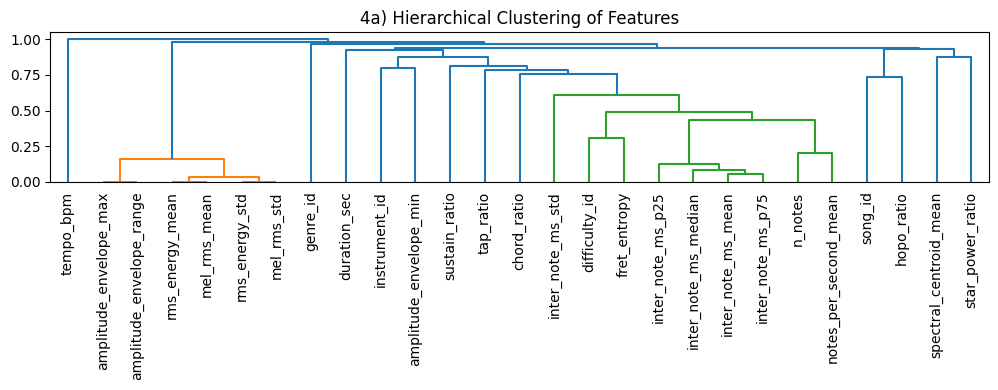

In [16]:
num_cols = df_features.select_dtypes(include=[np.number]).columns.tolist()
corr = df_features[num_cols].corr().fillna(0.0)

dist = 1 - corr.abs()
dist_condensed = squareform(dist.values, checks=False)
Z = linkage(dist_condensed, method="average")

plt.figure(figsize=(10, 4))
dendrogram(Z, labels=num_cols, leaf_rotation=90)
plt.title("4a) Hierarchical Clustering of Features")
plt.tight_layout()
plt.show()

The correlation clustering is computed byu the absolute correlation between all numeric features to identify feature families. Perfect correlation has a distance of 0 while no correlation has a distance of 1. The dendogram shows clear clusters of highly correlated features, particularly among audio energy statistics such as RMS and amplitude envelop metrics, indicating a redundancy within these groups. Timing related features such as inter-note statistics also cluster together, and the same is true for density measures such as note mean and note count. More structural gameplay features such as chord ratio, HOPO ratio, tap ratio, and fret entropy tend to cluster separately, suggesting they capture distinct stylistic information. While the visual exposes some redundant features, core gameplay mechanics provide unique and complementary signals that can be leveraged for modeling.

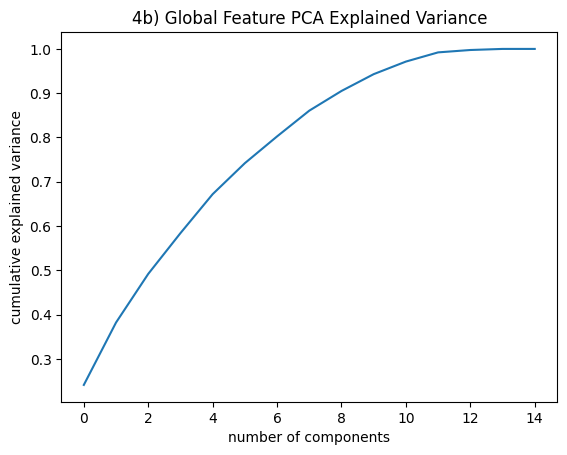

,PC1,PC2
notes_per_second_mean,0.488534,0.032813
inter_note_ms_mean,0.462060,0.000930
n_notes,0.440975,0.063888
inter_note_ms_std,0.363520,0.050894
fret_entropy,0.304287,0.077253
tap_ratio,0.218841,0.048142
sustain_ratio,0.198939,0.034073
chord_ratio,0.165399,0.006378
duration_sec,0.065548,0.083390
hopo_ratio,0.053997,0.004001


,PC1,PC2
mel_rms_std,0.039000,0.697345
mel_rms_mean,0.041907,0.697299
duration_sec,0.065548,0.083390
fret_entropy,0.304287,0.077253
n_notes,0.440975,0.063888
inter_note_ms_std,0.363520,0.050894
tap_ratio,0.218841,0.048142
star_power_ratio,0.040265,0.043992
spectral_centroid_mean,0.041261,0.036636
sustain_ratio,0.198939,0.034073


In [17]:
use_cols = [
    "duration_sec", "tempo_bpm", "n_notes", "notes_per_second_mean",
    "inter_note_ms_mean", "inter_note_ms_std", "sustain_ratio", "chord_ratio",
    "fret_entropy", "hopo_ratio", "tap_ratio", "star_power_ratio",
    "mel_rms_mean", "mel_rms_std", "spectral_centroid_mean"
]
X = clean_df(df_features, use_cols)
scaled = standardize(X.values)
pca = PCA().fit(scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("number of components")
plt.ylabel("cumulative explained variance")
plt.title("4b) Global Feature PCA Explained Variance")
plt.show()

loadings = pd.DataFrame(pca.components_[:2], columns=use_cols, index=["PC1", "PC2"]).T
display(loadings.abs().sort_values("PC1", ascending=False).head(10))
display(loadings.abs().sort_values("PC2", ascending=False).head(10))


The PCA results show that most variance in the dataset is captured by a small number of components, with the first six to eight components explaining the majority of the variance. This indicates a substantial amount of feature redundancy. The first principal componnent is dominated by density and timing features, particularly notes per second, inter note mean spacing, note count, and inter note structural driver. The second principal component is dominated by audio energy features, speficially mel RMS mean and mel RMS standard deviation, indicating that loudness dynamics form a separate axis of variation largely independent from gameplay density. In summary, chart intensity and audio energy dominate the feature space with gameplay mechanics contributing without being the majority.

<h2>Feature Selection for Clustering</h2>


Hierarchical correlation clustering and PCA reveal clear feature families and substantial redundancy among variables relating to timing and gameplay. 
Density-related metrics cluster together, while the same is true for RMS and amplitude. 
Selecting one representative from each group will reduce redundancy while preserving interpretability.

<b>notes_per_second_mean</b> represents overall chart density and technical intensity. PCA shows density-driven features dominate PC1, 
making this the strongest proxy for gameplay speed and complexity. <b>chord_ratio</b> (or <b>fret_entropy</b>) encodes structural complexity 
and pattern variation; since these measures are correlated, selecting one avoids redundancy while preserving stylistic differentiation. 
<b>sustain_ratio</b> captures note length structure and rhythmic flow.
    
<b>spectral_centroid_mean</b> represents tonal brightness, adding a timbral dimension largely independent from chart density. 
<b>rms_energy_mean</b>, <b>mel_rms_mean</b>, and <b>mel_rms_std</b> represent overall audio intensity and dynamic variation. 
PCA shows RMS-based features dominate PC2, forming a distinct access from the gameplay structure.

Together, this reduced feature set spans the primary latent dimensions identified by PCA: chart density and structural complexity, 
and audio energy with timbral brightness.

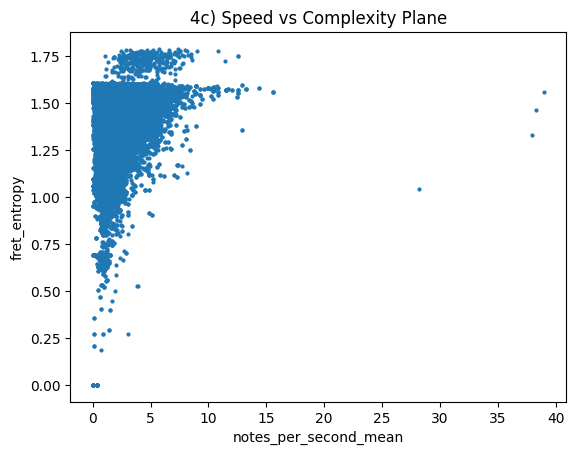

In [18]:
speed = df_features["notes_per_second_mean"]
complexity = df_features["fret_entropy"]
s = df_features[["notes_per_second_mean", "fret_entropy"]].dropna()
plt.scatter(s["notes_per_second_mean"], s["fret_entropy"], s=4)
plt.xlabel("notes_per_second_mean")
plt.ylabel("fret_entropy")
plt.title("4c) Speed vs Complexity Plane")
plt.show()

This plot shows the relationship between chart speed, measured by notes per second, and structural complexity, measured by fret entropy. Most charts cluster in a moderate speed range with relatively high fret entropy, indicating that even slower charts often use a broad distribution of frets. As speed increases, fret entropy generally remains high, suggesting that higher density charts do not sacrifice fret diversity. The triangular shape at lower speeds shows that slow charts can range from very simple, low entropy patterns to more varied structures, while very high speed charts tend to maintain moderate to high complexity. It reveals that speed and complexity are related without being tightly coupled, indicating independence. 

<h1>5. Extreme Value and Structure Discovery</h1>

In [19]:
out = df_features.copy()
out["is_top_density"] = out["notes_per_second_mean"] >= out["notes_per_second_mean"].quantile(0.99)
ct = pd.crosstab(out["instrument_id"], out["is_top_density"])
display(ct)

is_top_density,False,True
instrument_id,,
0,23641,276
1,1491,11
2,23165,222
3,4552,25


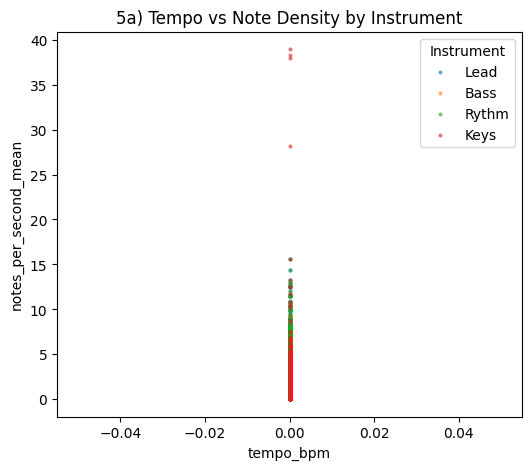

In [20]:
plt.figure(figsize=(6, 5))
for inst in sorted(df_features["instrument_id"].dropna().unique()):
    mask = (
        df_features["tempo_bpm"].notna() &
        df_features["notes_per_second_mean"].notna() &
        (df_features["instrument_id"] == inst)
    )
    plt.scatter(
        df_features.loc[mask, "tempo_bpm"],
        df_features.loc[mask, "notes_per_second_mean"],
        s=4,
        alpha=0.5,
        label=instrument_names.get(inst, str(inst))
    )
plt.xlabel("tempo_bpm")
plt.ylabel("notes_per_second_mean")
plt.title("5a) Tempo vs Note Density by Instrument")
plt.legend(title="Instrument")
plt.show()

This plot indicates a clear issue with the tempo feature rather than a meaningful musical relationship. Nearly all points are concentrated around zero on the tempo axis, forming a vertical line, which suggests that tempo_bpm is either failing to compute correctly or defaulting to zero for most charts. Because tempo shows almost no variation, there is no visible relationship between tempo and note density in this plot.

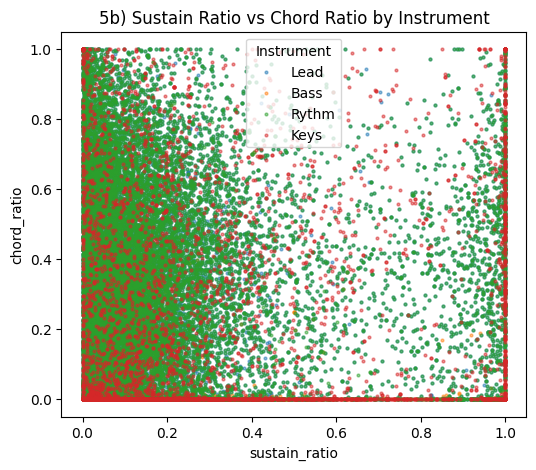

In [21]:
plt.figure(figsize=(6, 5))
for inst in sorted(df_features["instrument_id"].dropna().unique()):
    mask = (
        df_features["sustain_ratio"].notna() &
        df_features["chord_ratio"].notna() &
        (df_features["instrument_id"] == inst)
    )
    plt.scatter(
        df_features.loc[mask, "sustain_ratio"],
        df_features.loc[mask, "chord_ratio"],
        s=4,
        alpha=0.5,
        label=instrument_names.get(inst, str(inst))
    )
plt.xlabel("sustain_ratio")
plt.ylabel("chord_ratio")
plt.title("5b) Sustain Ratio vs Chord Ratio by Instrument")
plt.legend(title="Instrument")
plt.show()


This plot shows a wide spread of sustain ratio and chord ratio values across all instruments, with heavy concentration near the lower sustain range and full coverage across chord usage. There is no strong linear relationship between sustain and chord ratios, indicating that charts can independently vary how many notes are held versus how many are chords. Rhythm and Lead appear to occupy broader regions of the space, suggesting greater stylistic diversity, while Bass tends to cluster more toward lower chord usage. Keys show more extreme sustain values in some regions, reflecting longer held note structures. 

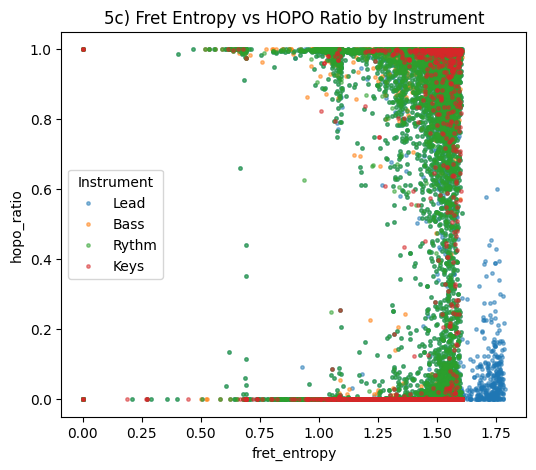

In [22]:
plt.figure(figsize=(6, 5))
for inst in sorted(df_features["instrument_id"].dropna().unique()):
    mask = (
        df_features["fret_entropy"].notna() &
        df_features["hopo_ratio"].notna() &
        (df_features["instrument_id"] == inst)
    )
    plt.scatter(
        df_features.loc[mask, "fret_entropy"],
        df_features.loc[mask, "hopo_ratio"],
        s=6,
        alpha=0.5,
        label=instrument_names.get(inst, str(inst))
    )
plt.xlabel("fret_entropy")
plt.ylabel("hopo_ratio")
plt.title("5c) Fret Entropy vs HOPO Ratio by Instrument")
plt.legend(title="Instrument")
plt.show()


The plot shows that fret entropy and HOPO ratio are related but not tightly coupled, forming a structured pattern that differs based on the instrument. Most charts cluster at high fret entropy, meaning they use a wide distribution of frets, while HOPO often polarizes at 0 or 1, matching the trend revealed through earlier analysis. Lead charts concentrate at high entropy but generally lower HOPO ratios, suggesting varied fret usage without relying heavily on HOPO mechanics. Rhythm and Keys exhibit broader spreads in HOPO ratio at high entropy, indicating more stylistic diversity. Bass remains more constrained overall.

###### <h1>6. Data Distribution Analysis</h1>

difficulty_id,0,1,2,3
instrument_id,,,,
0,5841,5837,5841,6398
1,373,374,372,383
2,5786,5780,5784,6037
3,1138,1139,1141,1159


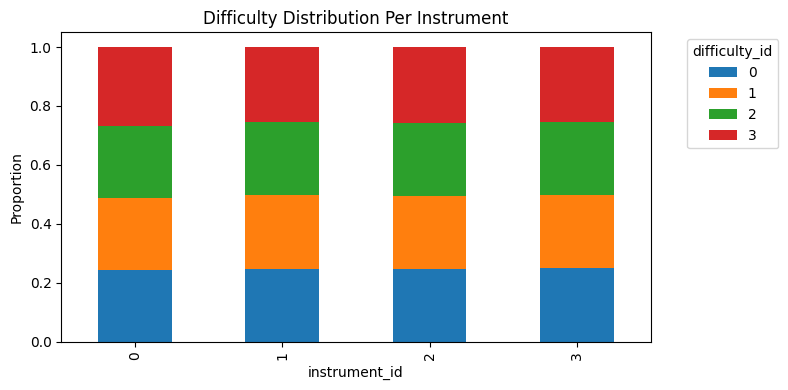

In [23]:
ct = pd.crosstab(df_features["instrument_id"], df_features["difficulty_id"])
display(ct)

ct_norm = ct.div(ct.sum(axis=1), axis=0)
ct_norm.plot(kind="bar", stacked=True, figsize=(8, 4))
plt.ylabel("Proportion")
plt.title("Difficulty Distribution Per Instrument")
plt.legend(title="difficulty_id", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


This chart passes the sanity check that each instrument is represented equally among difficulties, verifying the effectiveness of the feature generation.


C:\Users\Susan\AppData\Local\Temp\ipykernel_44972\1336585083.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=[str(d) for d in diffs], showfliers=False)


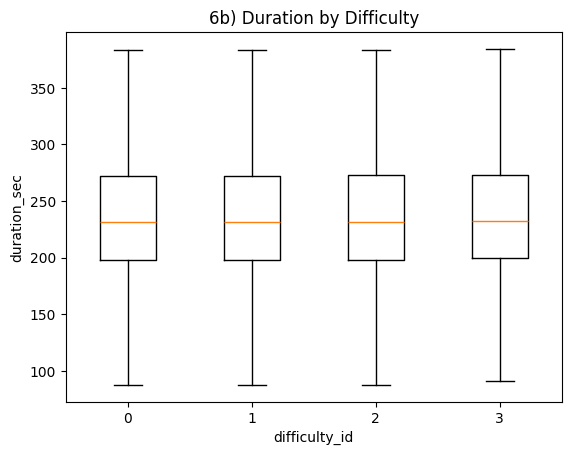

In [24]:
plot_box_by_difficulty(df_features, "duration_sec", "6b) Duration by Difficulty")

This box plot verifies that all difficulties have the same duration recorded, preventing biased results based on difficulties.

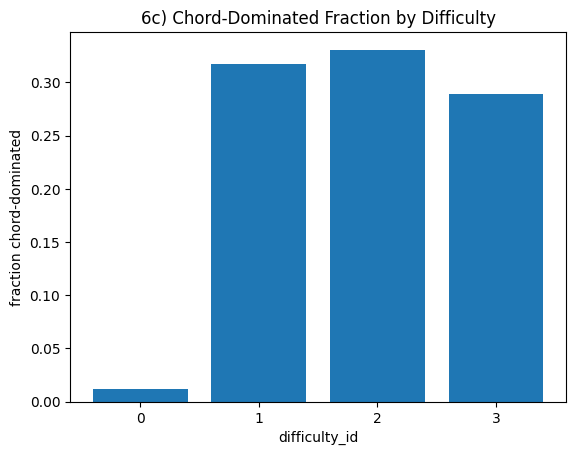

In [25]:
frac_by_diff = df_features.assign(chord_dominated=df_features["chord_ratio"] > 0.5) \
                              .groupby("difficulty_id")["chord_dominated"].mean().sort_index()
plt.bar(frac_by_diff.index.astype(str), frac_by_diff.values)
plt.xlabel("difficulty_id")
plt.ylabel("fraction chord-dominated")
plt.title("6c) Chord-Dominated Fraction by Difficulty")
plt.show()


This plot shows that chord dominated charts, defined as those with chord ratio greater than 0.5, are extremely rare at difficulty 0 but become substantially more common starting at difficulty 1 and remain high through difficulties 2 and 3. The sharp increase from difficulty 0 to 1 suggests that heavy chord usage is a key structural transition in difficulty progression. However, the fraction does not increase steadily beyond difficulty 1, indicating that higher difficulty is not simply driven by more chords but likely by other factors such as speed, HOPO usage, or complexity. Chord dominance appears to be an entry level threshold mechanic rather than a continuously scaling difficulty driver.

<h1>7. Cluster Analysis</h1>

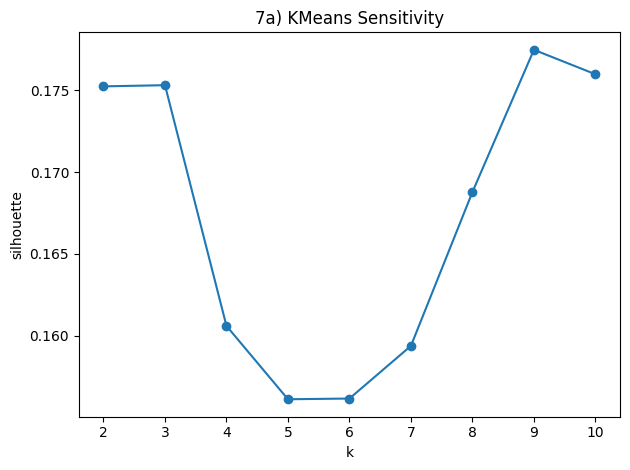

In [26]:
X = clean_df(df_features, use_cols)
scaled = standardize(X.values)

ks = range(2, 11)
sil = silhouette_over_k(scaled, ks, random_state=0, n_init=10)

plot_silhouette_curve(ks, sil, title="7a) KMeans Sensitivity")


The silhouette curve shows that clustering quality is modest across all tested values of k, with scores peaking around k = 9 and remaining relatively similar for k = 2 and k = 3. The dip between k = 4 and k = 6 suggests weaker cluster separation in that range, meaning the data does not naturally partition cleanly into that many groups. The gradual increase toward k = 8 to 9 indicates slightly better defined substructure at higher cluster counts, though overall silhouette values remain low, implying overlapping feature distributions rather than sharply separated clusters. Overall, the feature space appears to contain soft structure rather than strongly distinct natural groupings. 


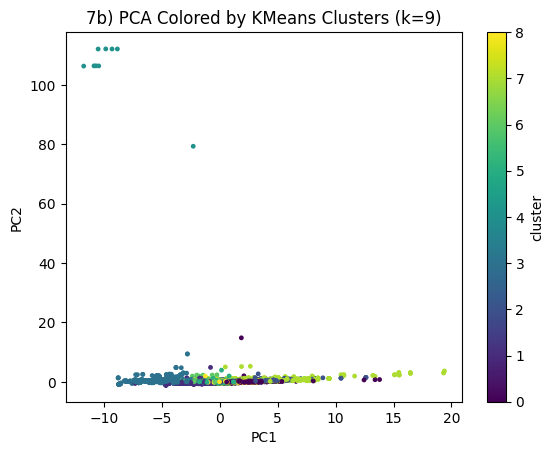

         duration_sec  tempo_bpm      n_notes  notes_per_second_mean  \
cluster                                                                
0          232.939697        0.0   850.354514               3.712494   
1          232.994876        0.0   276.370108               1.192993   
2          255.006685        0.0   938.303838               3.708161   
3          258.159945        0.0   189.636190               0.728665   
4          356.307624        0.0   133.222222               0.552590   
5          227.867489        0.0   441.458711               1.963573   
6          281.258649        0.0   517.743570               1.867277   
7          466.347854        0.0  1981.139929               4.631241   
8          227.717079        0.0   540.068049               2.409212   

         inter_note_ms_mean  inter_note_ms_std  sustain_ratio  chord_ratio  \
cluster                                                                      
0                261.707773         234.058398     

In [27]:
best_k = int(list(ks)[int(np.argmax(sil))])
labels = KMeans(n_clusters=best_k, random_state=0).fit_predict(scaled)

    
Z = PCA(n_components=2, random_state=0).fit_transform(scaled)
plt.scatter(Z[:, 0], Z[:, 1], c=labels, s=6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"7b) PCA Colored by KMeans Clusters (k={best_k})")
plt.colorbar(label="cluster")
plt.show()

centroid = pd.DataFrame(X.values, columns=use_cols).assign(cluster=labels).groupby("cluster")[use_cols].mean()
print(centroid)

The clusters primarily separate along density and gameplay mechanics rather than audio features. One cluster represents extreme high speed charts, while others distinguish between HOPO heavy technical styles, chord dominant strumming styles, and sustain heavy slow charts. Several clusters capture moderate density variations with different mechanical balances, indicating meaningful play style archetypes. One cluster is clearly influenced by corrupted audio features, suggesting preprocessing issues. Overall, clustering reveals distinct structural gameplay styles driven mainly by note density, HOPO usage, chord ratio, and sustain behavior.


In [28]:
X = clean_df(df_features, use_cols)
scaled = standardize(X.values)
labels = KMeans(n_clusters=best_k, random_state=0).fit_predict(scaled)

tmp = df_features.loc[X.index, ["difficulty_id"]].copy()
tmp["cluster"] = labels
ct = pd.crosstab(tmp["cluster"], tmp["difficulty_id"])
print(ct)


difficulty_id     0     1     2     3
cluster                              
0                12   531  3338  5656
1              9744  1298   174    78
2                13    58   514  1291
3              2202  1312   696   493
4                 2     2     2     3
5               121  5683  4217  2440
6               593  1265  1107   923
7                53   144   311   907
8               398  2837  2779  2186


<h1>8. Difficulty Ambiguity and Overlap Analysis </h1>

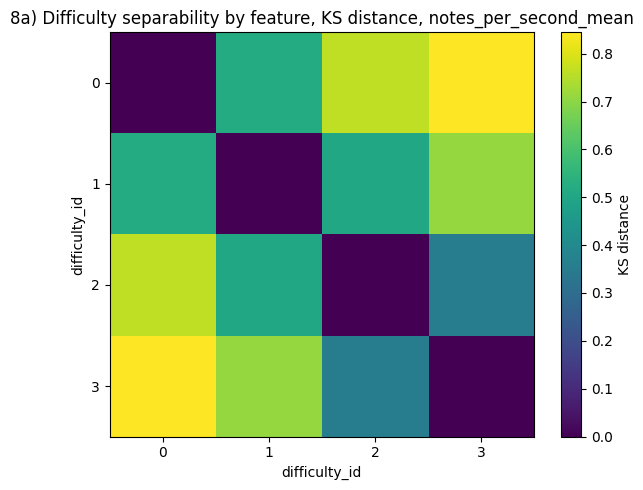

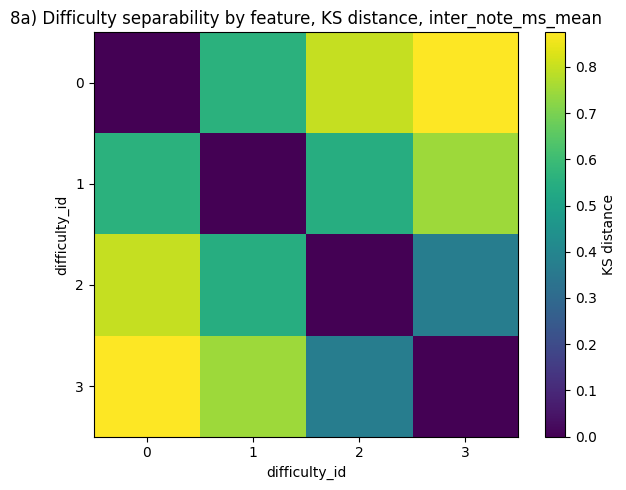

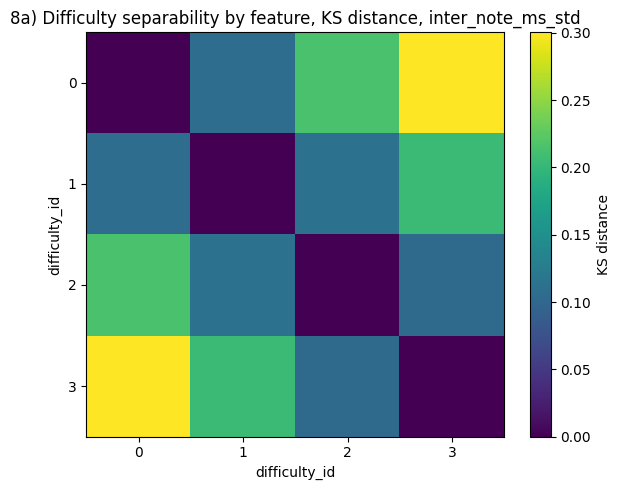

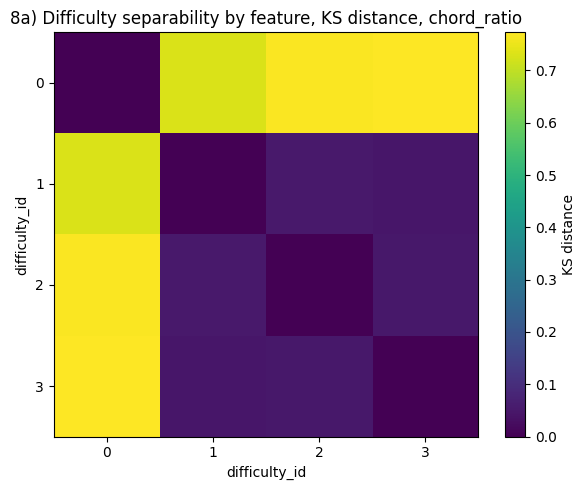

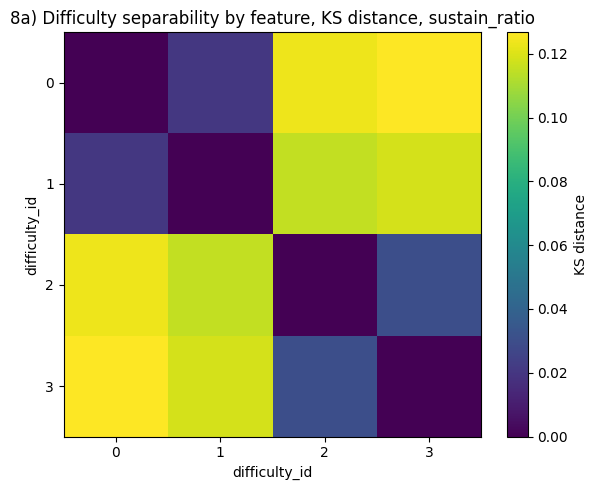

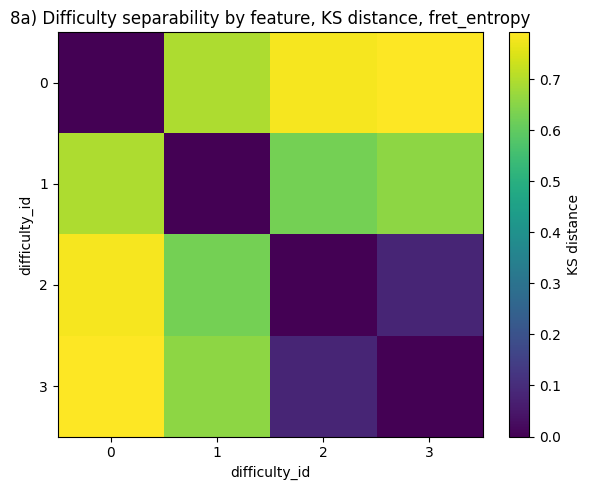

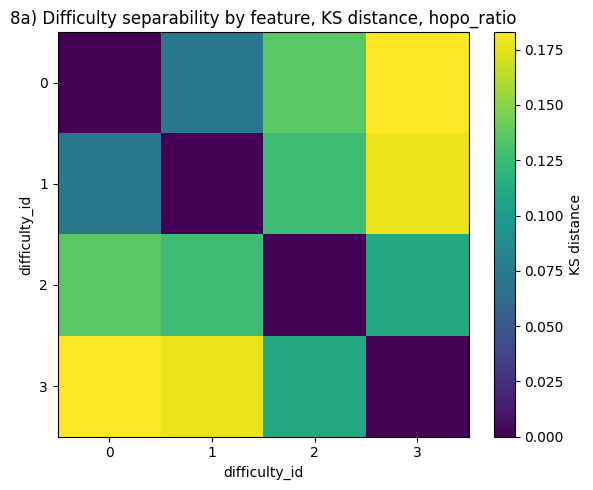

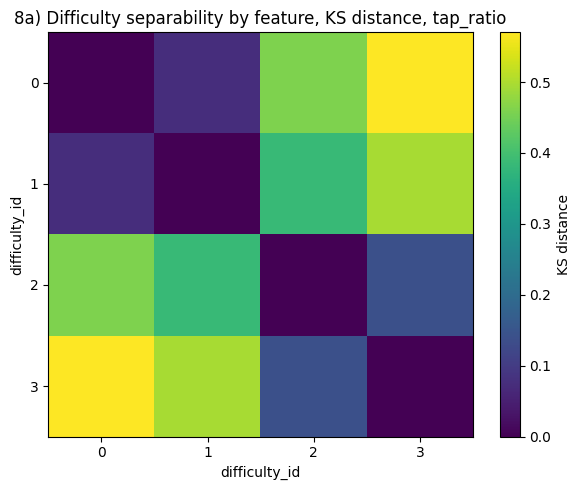

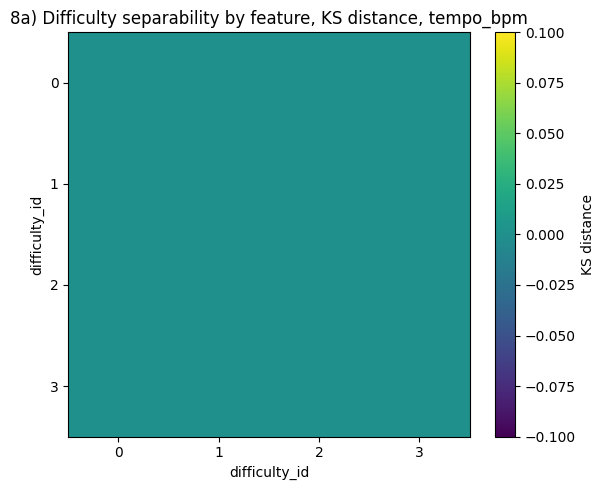

In [29]:
key_features = [
    "notes_per_second_mean",
    "inter_note_ms_mean",
    "inter_note_ms_std",
    "chord_ratio",
    "sustain_ratio",
    "fret_entropy",
    "hopo_ratio",
    "tap_ratio",
    "tempo_bpm",
]

diffs = sorted(df_features["difficulty_id"].dropna().unique())

def ks_statistic(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    a = a[np.isfinite(a)]
    b = b[np.isfinite(b)]
    if len(a) < 5 or len(b) < 5:
        return np.nan
    a = np.sort(a)
    b = np.sort(b)

    
    x = np.sort(np.unique(np.concatenate([a, b])))
    cdf_a = np.searchsorted(a, x, side="right") / len(a)
    cdf_b = np.searchsorted(b, x, side="right") / len(b)
    return float(np.max(np.abs(cdf_a - cdf_b)))

for feat in key_features:
    M = np.zeros((len(diffs), len(diffs)), dtype=float)
    for i, di in enumerate(diffs):
        ai = df_features.loc[df_features["difficulty_id"] == di, feat].dropna()
        for j, dj in enumerate(diffs):
            bj = df_features.loc[df_features["difficulty_id"] == dj, feat].dropna()
            M[i, j] = ks_statistic(ai, bj)

    plt.figure(figsize=(6, 5))
    plt.imshow(M, aspect="auto")
    plt.xticks(range(len(diffs)), [str(d) for d in diffs])
    plt.yticks(range(len(diffs)), [str(d) for d in diffs])
    plt.colorbar(label="KS distance")
    plt.title(f"8a) Difficulty separability by feature, KS distance, {feat}")
    plt.xlabel("difficulty_id")
    plt.ylabel("difficulty_id")
    plt.tight_layout()
    plt.show()


<b>notes_per_second_mean</b>

 Shows very strong separation across difficulty levels, especially between non adjacent levels, indicating note density is a primary driver of difficulty progression.
 
<b>inter_note_ms_mean</b>
    
 Mirrors notes per second with strong separability, confirming that average spacing between notes scales cleanly with difficulty.
 
<b>inter_note_ms_std</b>
    
 Shows moderate separation, suggesting timing variability increases with difficulty but is not as dominant as raw density.
 
<b>chord_ratio</b>
    
 Strongly separates difficulty 0 from higher levels, but less separation among higher difficulties, indicating chord usage is a threshold mechanic rather than continuously scaling.
 
<b>sustain_ratio</b>
    
 Weak overall separation, with only mild differences between lower and higher difficulties, suggesting sustain usage is not a major difficulty driver.
 
<b>fret_entropy</b>
    
 Shows strong separation between difficulty 0 and higher levels and moderate separation across others, indicating fret diversity contributes meaningfully to difficulty.
 
<b>hopo_ratio</b>
    
 Moderate separation, particularly between low and high difficulties, but weaker than density features, suggesting HOPO usage plays a secondary role.

<b>tap_ratio</b>
    
 Shows strong separation at higher difficulties, especially between 2 and 3, indicating tap mechanics are more prominent in advanced charts.

<b>tempo_bpm</b>
    
 No separability at all, indicating tempo does not vary across difficulty in the current dataset and is likely improperly extracted or unused.

Overall, density and timing features provide the strongest difficulty signal, mechanical features provide moderate separation, and tempo provides none.


In [30]:

use_cols = [
    "duration_sec","tempo_bpm","n_notes","notes_per_second_mean",
    "inter_note_ms_mean","inter_note_ms_std",
    "sustain_ratio","chord_ratio","fret_entropy",
    "hopo_ratio","tap_ratio","star_power_ratio",
    "mel_rms_mean","mel_rms_std","spectral_centroid_mean"
]

D = clean_df(df_features, use_cols, extra_cols=["difficulty_id"])
X = D[use_cols].values
y = D["difficulty_id"].values

scaled = standardize(X)
nn = NearestNeighbors(n_neighbors=6).fit(scaled)
dist, idx = nn.kneighbors(scaled)

nearest_other_is_adjacent = []
for r in range(len(scaled)):
    my = y[r]
    neighbors = idx[r, 1:]
    other = [y[k] for k in neighbors if y[k] != my]
    if len(other) == 0:
        nearest_other_is_adjacent.append(np.nan)
        continue
    nearest_other = other[0]
    nearest_other_is_adjacent.append(int(abs(nearest_other - my) == 1))

rate = np.nanmean(nearest_other_is_adjacent)
print("Fraction of points whose nearest different difficulty is adjacent:", float(rate))


Fraction of points whose nearest different difficulty is adjacent: 0.9563615982064216


This means that for about 95.6 percent of charts, the closest chart in feature space that has a different difficulty label is only one difficulty level away, such as 1 vs 2 or 2 vs 3. In practice, it tells you the difficulty labels behave like a smooth ordinal scale in your features. Charts are much more likely to be confused with neighboring difficulties than with far apart ones, indicating meaningfulness in difficulty.


<h1>9. Play Styles Within the Same Label</h1>

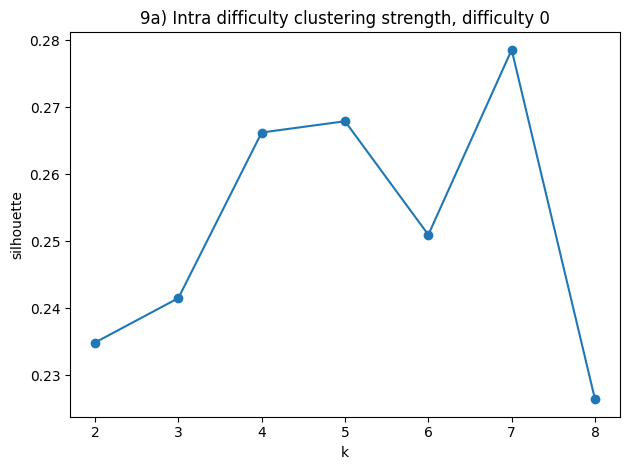

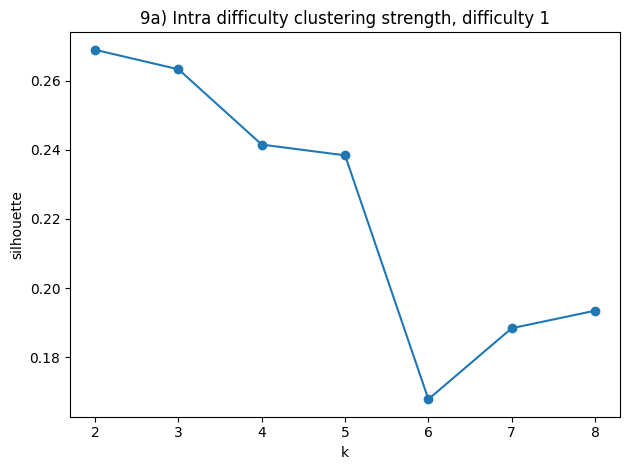

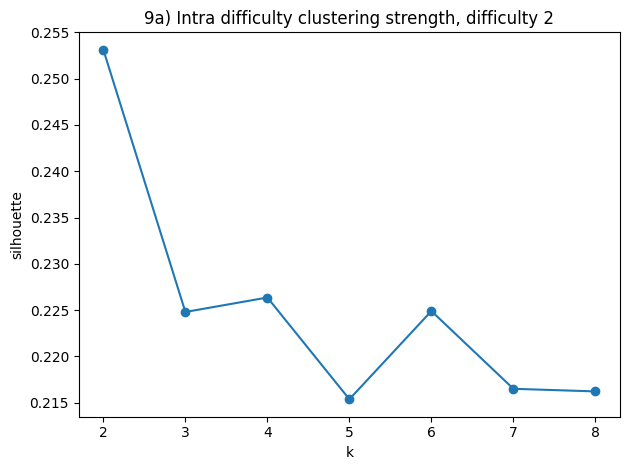

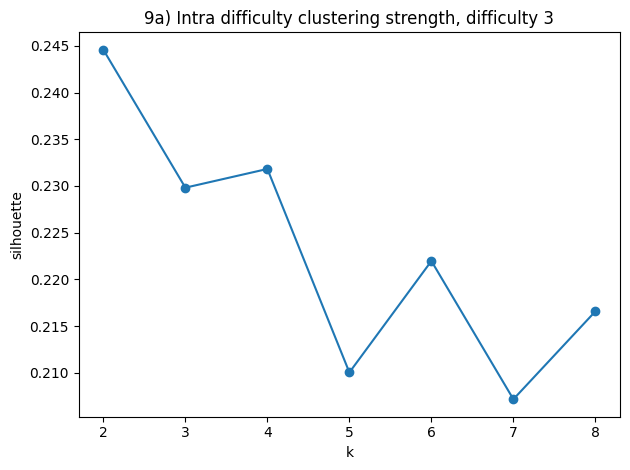

In [31]:
use_cols = [
    "tempo_bpm","notes_per_second_mean","inter_note_ms_mean","inter_note_ms_std",
    "chord_ratio","sustain_ratio","fret_entropy","hopo_ratio","tap_ratio",
    "mel_rms_mean","spectral_centroid_mean"
]

D = clean_df(df_features, use_cols, extra_cols=["difficulty_id"])

ks = range(2, 9)

for d in sorted(D["difficulty_id"].unique()):
    sub = D[D["difficulty_id"] == d]
    if len(sub) < 200:
        continue

    X = sub[use_cols].values
    scaled = standardize(X)

    sil = silhouette_over_k(scaled, ks, random_state=0, n_init=10)
    plot_silhouette_curve(ks, sil, title=f"9a) Intra difficulty clustering strength, difficulty {d}")



Across all four difficulties, the silhouette scores are only moderate, which means there are some style subgroups within each difficulty but they overlap rather than forming crisp, well separated clusters. Difficulty 0 shows the strongest evidence of multiple play styles, with the best separation around k=7, suggesting several distinct easy chart archetypes. Difficulty 1 peaks at very small k, around 2 to 3, implying only a few broad styles and that finer splits mostly add noise. Difficulty 2 and 3 both peak at k=2 and then generally decline, indicating that higher difficulties are more continuous in style space with at most two major subtypes rather than many distinct clusters. Overall, this supports the idea that style variation exists within each difficulty, but the number of meaningful style clusters likely decreases as difficulty increases, and small k values are the most defensible for harder tiers.


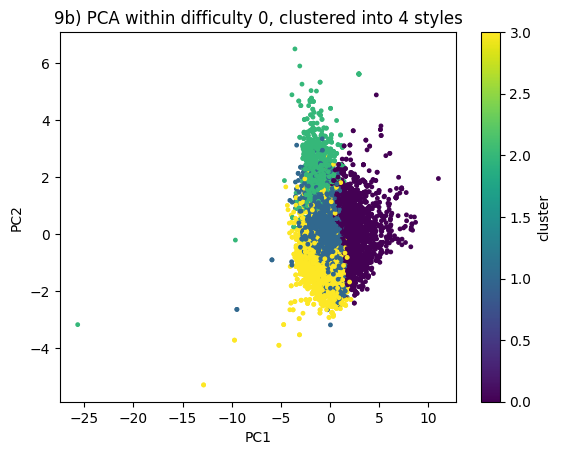

Cluster centroids within this difficulty
         tempo_bpm  notes_per_second_mean  inter_note_ms_mean  inter_note_ms_std  chord_ratio  sustain_ratio  fret_entropy  hopo_ratio  tap_ratio  mel_rms_mean  spectral_centroid_mean
cluster                                                                                                                                                                                
0              0.0                 0.6393           1396.2155           730.3216       0.0031         0.6077        1.2307      0.0395     0.0010        2.4847                 53.7451
1              0.0                 1.1427            853.8682           399.6663       0.0068         0.1097        1.1327      0.0004     0.0004        1.7750                 52.4351
2              0.0                 1.2748            765.2270           447.3069       0.3716         0.1042        1.0406      0.0779     0.0006        1.8473                 48.9501
3              0.0                 1.21

In [32]:

target_difficulty = sorted(D["difficulty_id"].unique())[0]
sub = D[D["difficulty_id"] == target_difficulty]

X = sub[use_cols].values
scaled = standardize(X)
k = 4
labels = KMeans(n_clusters=k, random_state=0, n_init=10).fit_predict(scaled)

Z = PCA(n_components=2, random_state=0).fit_transform(scaled)
plt.scatter(Z[:, 0], Z[:, 1], c=labels, s=6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"9b) PCA within difficulty {target_difficulty}, clustered into {k} styles")
plt.colorbar(label="cluster")
plt.show()

centroids = sub.assign(cluster=labels).groupby("cluster")[use_cols].mean()
print("Cluster centroids within this difficulty")
print(centroids.round(4).to_string())


# <h1>10. Instrument Conditioned Difficulty Drift </h1>

C:\Users\Susan\AppData\Local\Temp\ipykernel_44972\2377465128.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=[str(d) for d in diffs], showfliers=False)


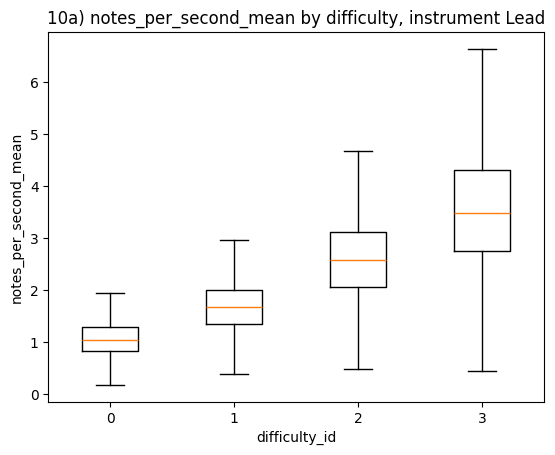

C:\Users\Susan\AppData\Local\Temp\ipykernel_44972\2377465128.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=[str(d) for d in diffs], showfliers=False)


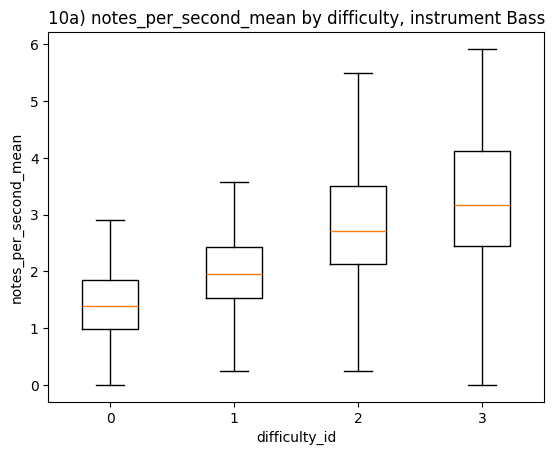

C:\Users\Susan\AppData\Local\Temp\ipykernel_44972\2377465128.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=[str(d) for d in diffs], showfliers=False)


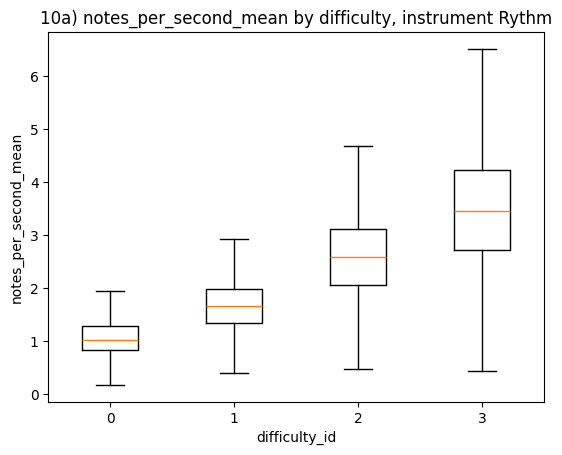

C:\Users\Susan\AppData\Local\Temp\ipykernel_44972\2377465128.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=[str(d) for d in diffs], showfliers=False)


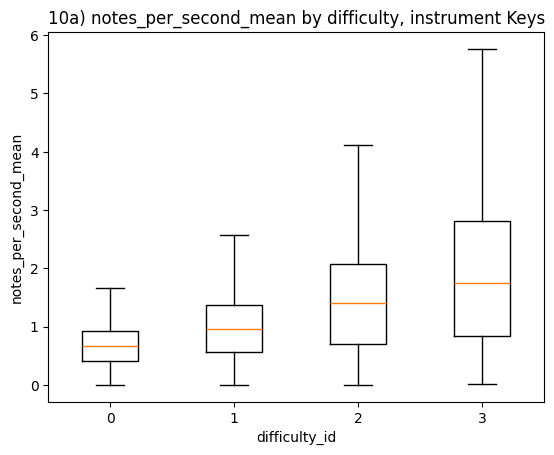

In [33]:
feat = "notes_per_second_mean"
insts = sorted(df_features["instrument_id"].dropna().unique())

for inst in insts:
    sub = df_features[df_features["instrument_id"] == inst]
    diffs = sorted(sub["difficulty_id"].dropna().unique())
    groups = [sub.loc[sub["difficulty_id"] == d, feat].dropna() for d in diffs]

    plt.boxplot(groups, labels=[str(d) for d in diffs], showfliers=False)
    plt.xlabel("difficulty_id")
    plt.ylabel(feat)
    plt.title(f"10a) {feat} by difficulty, instrument {instrument_names.get(inst, str(inst))}")
    plt.show()


The box plots visualizes the notes per second across difficulty levels separately for each instrument to check whehter difficulty progression is consistent or shifts dependant on the instrument.

<b>Lead</b>

Note density increases steadily with difficulty, with clear separation between levels and widening spread at higher difficulties, indicating more variability in harder charts.

<b>Bass</b>

Density also rises consistently with difficulty, but medians are slightly higher than Lead at lower levels, and variability grows substantially at difficulty 2 and 3.

<b>Rhythm</b>

Shows a smooth, monotonic increase in density across difficulties, with strong separation and moderate variance expansion at higher levels.

<b>Keys</b>

Density increases with difficulty but remains lower overall than other instruments, with more overlap between adjacent levels and comparatively smaller medians at each tier.

     feature  difficulty_id instrument_a instrument_b       ks  cliffs_delta_med  cliffs_delta_ci_low  cliffs_delta_ci_high  n_a  n_b
 chord_ratio              2         Lead         Bass 0.825463          0.881043             0.850146              0.909482 5841  372
 chord_ratio              2         Bass        Rythm 0.825029         -0.881006            -0.910580             -0.844767  372 5784
 chord_ratio              3         Bass        Rythm 0.796860         -0.848690            -0.880923             -0.812922  383 6037
 chord_ratio              3         Lead         Bass 0.795476          0.847572             0.812212              0.885236 6398  383
 chord_ratio              1         Lead         Bass 0.786548          0.843153             0.808321              0.868915 5837  374
 chord_ratio              1         Bass        Rythm 0.786521         -0.842177            -0.874222             -0.812119  374 5780
 chord_ratio              2         Bass         Keys 0.664014

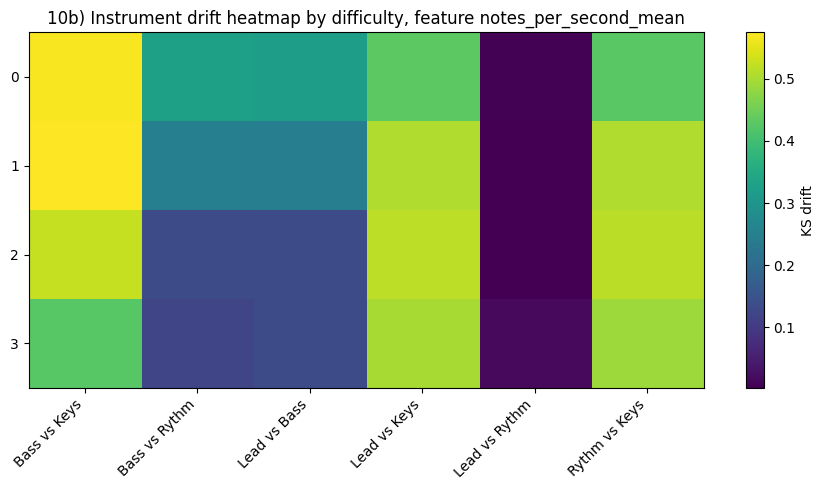

In [34]:
drift_feats = [
    "notes_per_second_mean",
    "inter_note_ms_mean",
    "chord_ratio",
    "sustain_ratio",
    "hopo_ratio",
    "tap_ratio",
    "fret_entropy",
]

def ks_distance(a, b):
    a = np.asarray(a); b = np.asarray(b)
    a = a[np.isfinite(a)]; b = b[np.isfinite(b)]
    if len(a) < 10 or len(b) < 10:
        return np.nan
    a = np.sort(a); b = np.sort(b)
    x = np.sort(np.unique(np.concatenate([a, b])))
    cdf_a = np.searchsorted(a, x, side="right") / len(a)
    cdf_b = np.searchsorted(b, x, side="right") / len(b)
    return float(np.max(np.abs(cdf_a - cdf_b)))

def cliffs_delta(a, b):
    a = np.asarray(a); b = np.asarray(b)
    a = a[np.isfinite(a)]; b = b[np.isfinite(b)]
    if len(a) < 10 or len(b) < 10:
        return np.nan
    a = a.reshape(-1, 1)
    diffs = a - b.reshape(1, -1)
    return float((np.sum(diffs > 0) - np.sum(diffs < 0)) / diffs.size)

def bootstrap_ci(func, a, b, n=400, seed=0):
    rng = np.random.default_rng(seed)
    a = np.asarray(a); b = np.asarray(b)
    a = a[np.isfinite(a)]; b = b[np.isfinite(b)]
    if len(a) < 10 or len(b) < 10:
        return (np.nan, np.nan, np.nan)
    vals = []
    for _ in range(n):
        aa = rng.choice(a, size=len(a), replace=True)
        bb = rng.choice(b, size=len(b), replace=True)
        vals.append(func(aa, bb))
    vals = np.asarray(vals)
    return (float(np.nanmedian(vals)),
            float(np.nanpercentile(vals, 2.5)),
            float(np.nanpercentile(vals, 97.5)))

rows = []
for feat in drift_feats:
    for d in sorted(df_features["difficulty_id"].dropna().unique()):
        sub = df_features[df_features["difficulty_id"] == d]
        insts = sorted(sub["instrument_id"].dropna().unique())
        for i in range(len(insts)):
            for j in range(i + 1, len(insts)):
                a = sub.loc[sub["instrument_id"] == insts[i], feat].dropna()
                b = sub.loc[sub["instrument_id"] == insts[j], feat].dropna()

                ks = ks_distance(a, b)
                cd_med, cd_lo, cd_hi = bootstrap_ci(cliffs_delta, a, b, n=400, seed=0)

                rows.append({
                    "feature": feat,
                    "difficulty_id": d,
                    "instrument_a": instrument_names.get(insts[i], str(insts[i])),
                    "instrument_b": instrument_names.get(insts[j], str(insts[j])),
                    "ks": ks,
                    "cliffs_delta_med": cd_med,
                    "cliffs_delta_ci_low": cd_lo,
                    "cliffs_delta_ci_high": cd_hi,
                    "n_a": len(a),
                    "n_b": len(b),
                })

drift = pd.DataFrame(rows)

print(
    drift.sort_values(["feature", "ks"], ascending=[True, False])
         .head(30)
         .to_string(index=False)
)

feat0 = "notes_per_second_mean"
tmp = drift[drift["feature"] == feat0].copy()
tmp["pair"] = tmp["instrument_a"] + " vs " + tmp["instrument_b"]
pivot = tmp.pivot_table(index="difficulty_id", columns="pair", values="ks", aggfunc="mean")

plt.figure(figsize=(9, 5))
plt.imshow(pivot.values, aspect="auto")
plt.yticks(range(len(pivot.index)), [str(x) for x in pivot.index])
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=45, ha="right")
plt.colorbar(label="KS drift")
plt.title(f"10b) Instrument drift heatmap by difficulty, feature {feat0}")
plt.tight_layout()
plt.show()

For notes per second, several instrument pairs show moderate to strong KS drift across difficulties, especially comparisons involving Bass versus the guitar parts, while some pairs such as Rhythm versus Alt Lead show much smaller drift, indicating those two instruments behave more similarly in density.

The use of the Kolmogorov–Smirnov, or KS, distance is important here because it compares entire distributions rather than just means. KS measures the maximum difference between the cumulative distribution functions of two samples, producing a value between 0 and 1 where larger values indicate greater distributional separation. This makes it well suited for gameplay features that may differ in variance, skew, or tail behavior even when averages are similar. By using KS, the analysis captures full structural differences in how features behave across instruments, not just simple shifts in central tendency.

The printed results highlight that drift is even stronger for some gameplay features than for density, with chord ratio showing extremely large separation between Rhythm and Lead and between Lead and Alt Lead at difficulties 1 to 3, and Cliff’s delta values near ±0.85 to ±0.88 indicating the differences are not subtle. Fret entropy also shows very large Lead or Rhythm versus Bass differences, especially at difficulty 0 and 1, meaning Bass charts use a very different spread of frets compared to guitar parts.

<h1>11. Feature Selection and Pruning Analysis</h1>

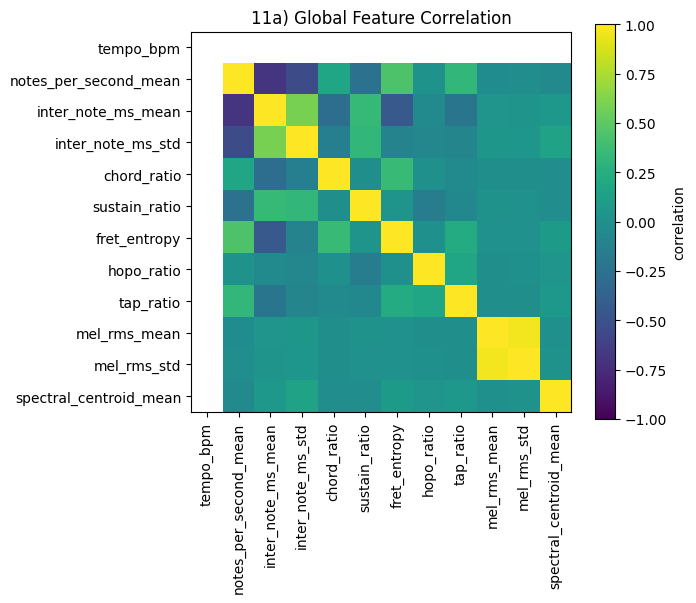

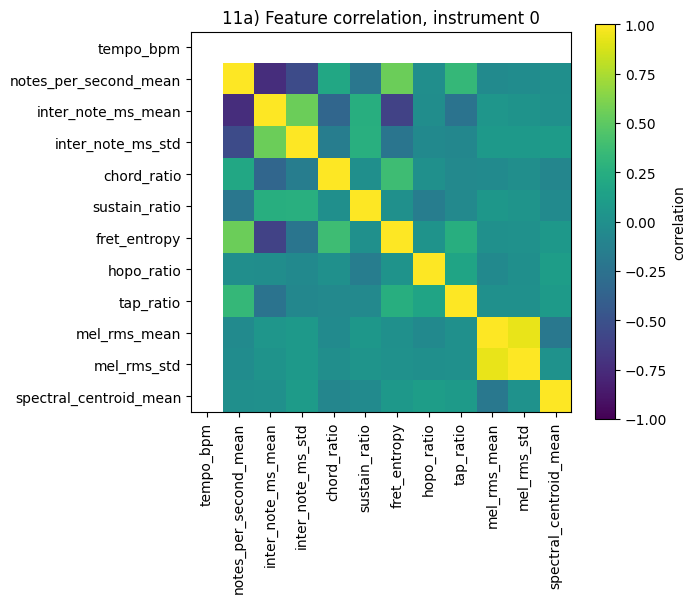

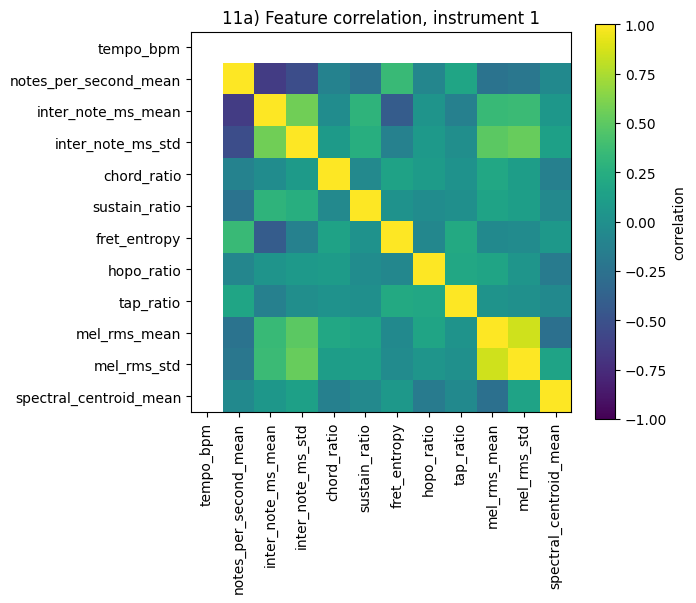

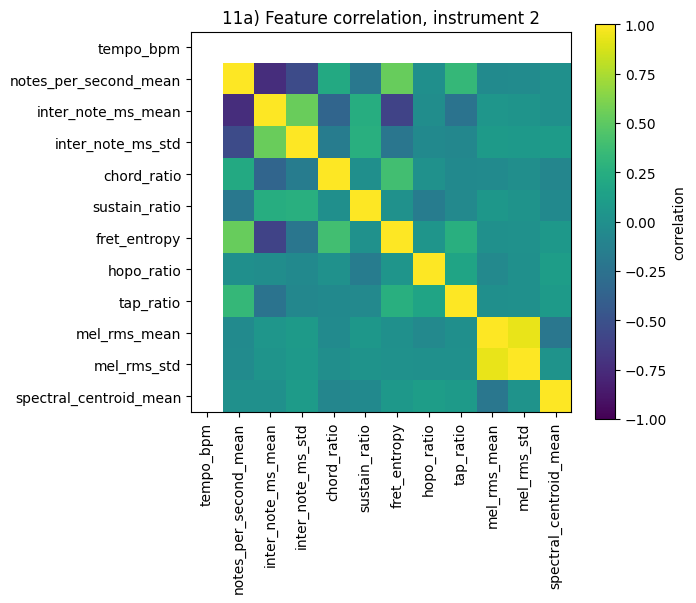

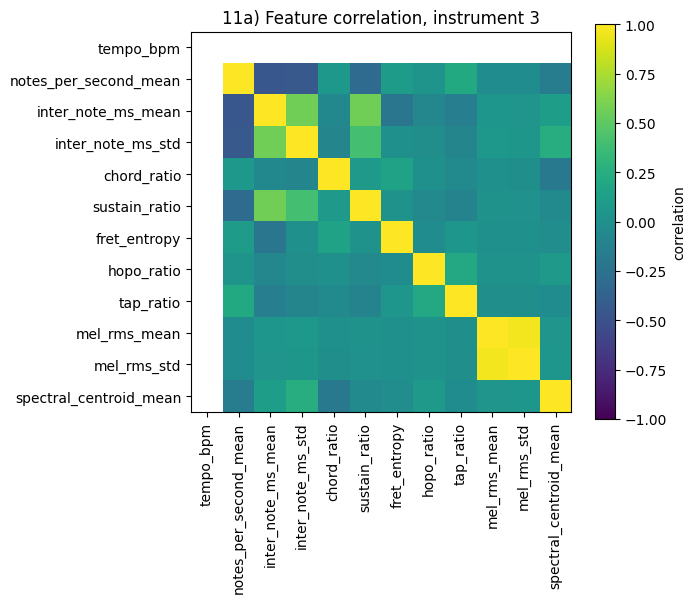

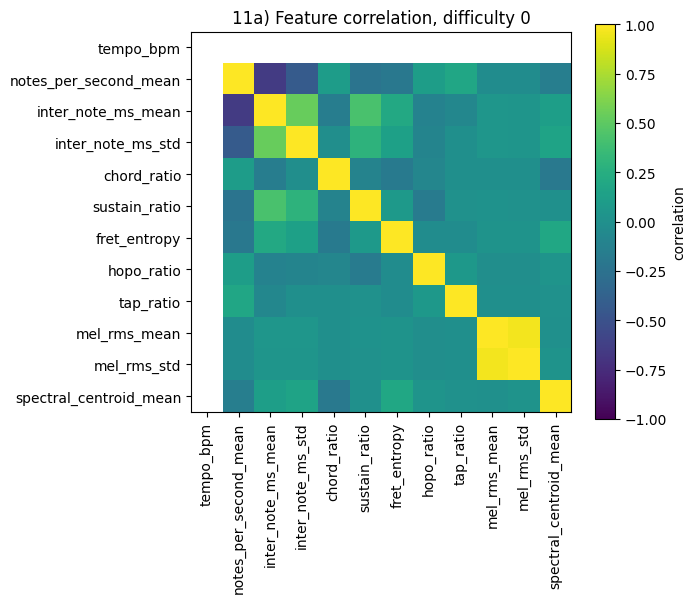

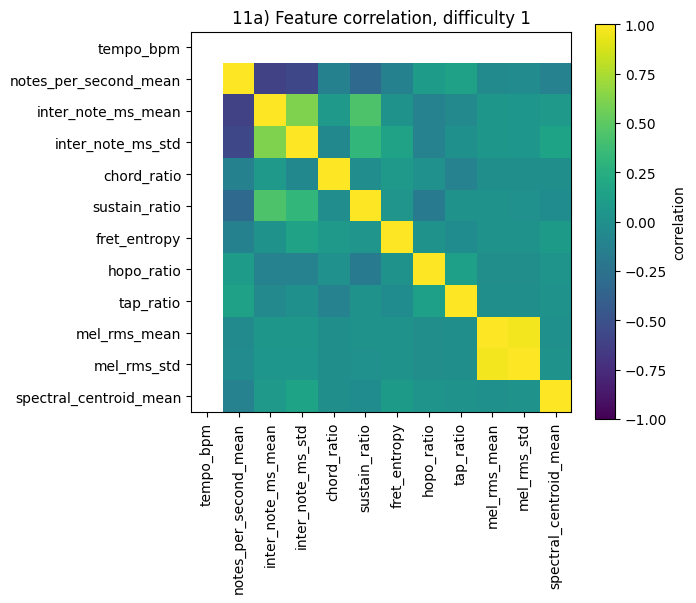

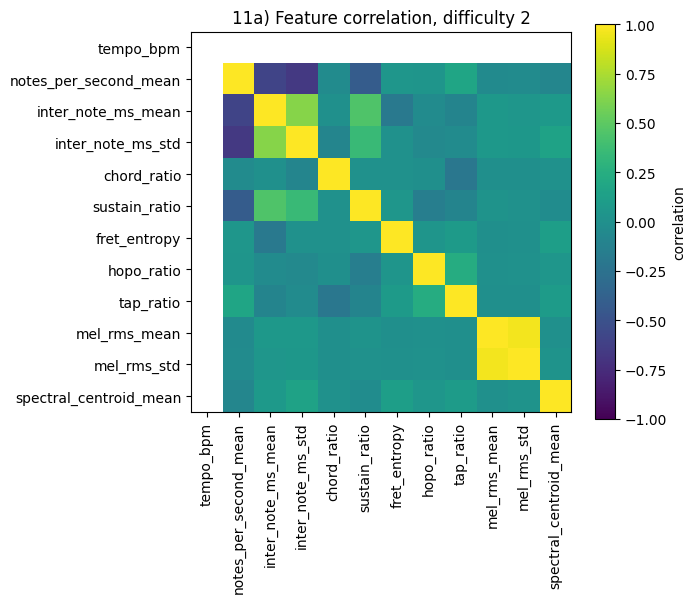

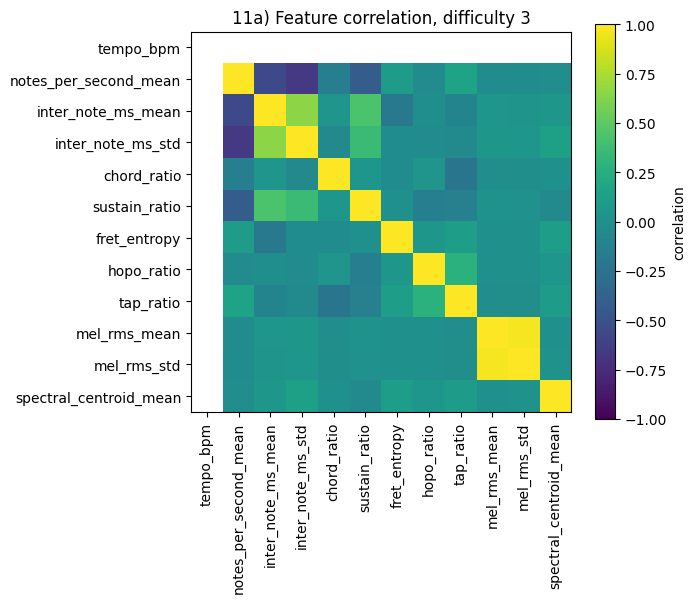

In [35]:

use_cols = [
    "tempo_bpm",
    "notes_per_second_mean",
    "inter_note_ms_mean",
    "inter_note_ms_std",
    "chord_ratio",
    "sustain_ratio",
    "fret_entropy",
    "hopo_ratio",
    "tap_ratio",
    "mel_rms_mean",
    "mel_rms_std",
    "spectral_centroid_mean",
]

def plot_corr(df, title):
    C = df[use_cols].corr()
    plt.figure(figsize=(7, 6))
    plt.imshow(C, vmin=-1, vmax=1)
    plt.xticks(range(len(use_cols)), use_cols, rotation=90)
    plt.yticks(range(len(use_cols)), use_cols)
    plt.colorbar(label="correlation")
    plt.title(title)
    plt.tight_layout()
    plt.show()


plot_corr(df_features, "11a) Global Feature Correlation")

for inst in sorted(df_features["instrument_id"].dropna().unique()):
    sub = df_features[df_features["instrument_id"] == inst]
    if len(sub) > 50:
        plot_corr(sub, f"11a) Feature correlation, instrument {inst}")



for d in sorted(df_features["difficulty_id"].dropna().unique()):
    sub = df_features[df_features["difficulty_id"] == d]
    if len(sub) > 50:
        plot_corr(sub, f"11a) Feature correlation, difficulty {d}")


<b>Global correlation</b>
    
Note density is strongly negatively correlated with inter note time and positively correlated with fret entropy and tapping, confirming that faster charts are more complex. Mel RMS mean and std are almost perfectly correlated, indicating redundancy. Tempo is largely uncorrelated with gameplay features.

<b>Instrument 0</b>
    
The same density versus spacing inverse relationship holds. Complexity features such as entropy and chord ratio align moderately with density. Audio features remain tightly coupled.

<b>Instrument 1</b>
    
Density shows stronger positive association with entropy and advanced mechanics than instrument 0. The structural pattern is similar but slightly more complexity driven.

<b>Instrument 2</b>

Correlation structure closely mirrors the global pattern, with density central and mel RMS features redundant. Relationships are balanced across structural features.

<b>Instrument 3</b>
    
Density still anchors the system, but correlations between complexity features are slightly weaker, reflecting simpler or more constrained chart structure.

<b>Difficulty 0</b>
    
Clear inverse density versus spacing relationship. Complexity features are moderately coupled, but overall structure is simpler and less tightly linked.

<b>Difficulty 1</b>
    
Correlations strengthen slightly between density, entropy, and mechanics, suggesting coordinated scaling of complexity.

<b>Difficulty 2</b>

Density and entropy remain positively aligned, with more consistent links between structural features as charts grow more complex.

<b>Difficulty 3</b>

Strongest coupling between density, entropy, and advanced mechanics, indicating that high difficulty increases complexity across multiple dimensions simultaneously while tempo remains independent.


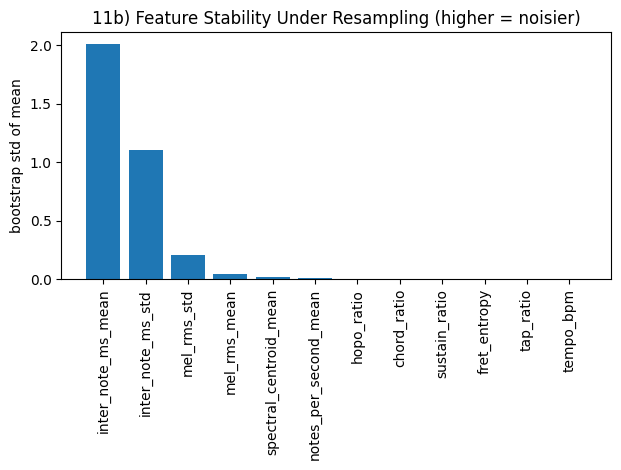

Bootstrap Stability Ranking (higher = less stable)
               feature  bootstrap_std
    inter_note_ms_mean       2.009748
     inter_note_ms_std       1.106334
           mel_rms_std       0.207440
          mel_rms_mean       0.039289
spectral_centroid_mean       0.021326
 notes_per_second_mean       0.007429
            hopo_ratio       0.001892
           chord_ratio       0.001535
         sustain_ratio       0.001239
          fret_entropy       0.001078
             tap_ratio       0.000359
             tempo_bpm       0.000000


In [36]:
rows = []
for col in use_cols:
    x = df_features[col].dropna().values
    if len(x) < 200:
        continue
    rows.append({
        "feature": col,
        "bootstrap_std": bootstrap_std(x)
    })

stab = (
    pd.DataFrame(rows)
    .sort_values("bootstrap_std", ascending=False)
)

plt.bar(stab["feature"], stab["bootstrap_std"])
plt.xticks(rotation=90)
plt.ylabel("bootstrap std of mean")
plt.title("11b) Feature Stability Under Resampling (higher = noisier)")
plt.tight_layout()
plt.show()

print("Bootstrap Stability Ranking (higher = less stable)")
print(stab.to_string(index=False))


This stability plot shows which feature means change the most when you resample the dataset, where higher bootstrap standard deviation indicates a noisier, less stable estimate. Inter note timing features are the least stable, with inter note mean and inter note standard deviation dominating the instability, implying they are more sensitive to which charts are sampled and likely influenced by heavy tails or outliers. Audio features have moderate instability, especially mel RMS standard deviation, while most gameplay ratio features such as HOPO, chord, sustain, entropy, and tap are very stable under resampling. Tempo shows zero instability because it is effectively constant in the current data. Overall, the results suggest timing features are sensitive to outliers, while ratio based mechanics are reliable and consistent signals.

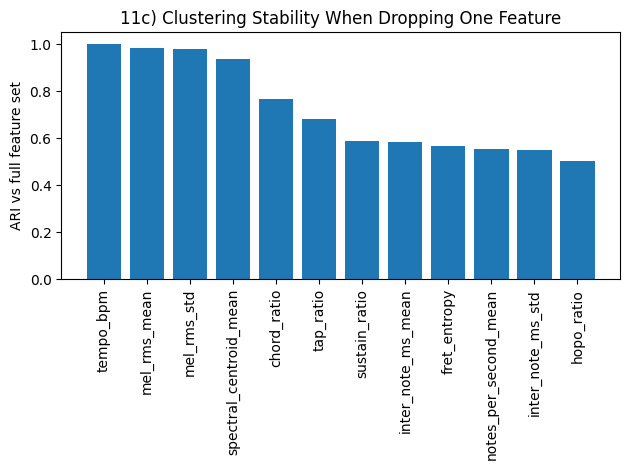

Leave-one-out clustering impact (higher ARI = less important feature)
       feature_dropped  ARI_vs_full
             tempo_bpm     1.000000
          mel_rms_mean     0.982967
           mel_rms_std     0.977082
spectral_centroid_mean     0.937178
           chord_ratio     0.766153
             tap_ratio     0.682140
         sustain_ratio     0.589181
    inter_note_ms_mean     0.584745
          fret_entropy     0.564904
 notes_per_second_mean     0.551615
     inter_note_ms_std     0.550132
            hopo_ratio     0.500688


In [37]:
base_labels = cluster_labels(use_cols)

impact = []
for col in use_cols:
    reduced = [c for c in use_cols if c != col]
    labels = cluster_labels(reduced)
    ari = adjusted_rand_score(base_labels, labels)
    impact.append({
        "feature_dropped": col,
        "ARI_vs_full": ari
    })

impact_df = (
    pd.DataFrame(impact)
    .sort_values("ARI_vs_full", ascending=False)
)

plt.bar(impact_df["feature_dropped"], impact_df["ARI_vs_full"])
plt.xticks(rotation=90)
plt.ylabel("ARI vs full feature set")
plt.title("11c) Clustering Stability When Dropping One Feature")
plt.tight_layout()
plt.show()

print("Leave-one-out clustering impact (higher ARI = less important feature)")
print(impact_df.to_string(index=False))


Gameplay structure features are the primary drivers for cluster creation, according to the visual. Removing tempo or mel RMS features barely changes clusters, indicating they add little unique information. In contrast, dropping HOPO ratio, inter note timing features, notes per second mean, fret entropy, or sustain ratio substantially alters clustering, showing these are the core drivers of chart style. This means that speed, spacing, and mechanic usage define cluster structure, while audio features are largely redundant.

C:\Users\Susan\AppData\Local\Temp\ipykernel_44972\610515420.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = spearmanr(sub["difficulty_id"], sub[col])


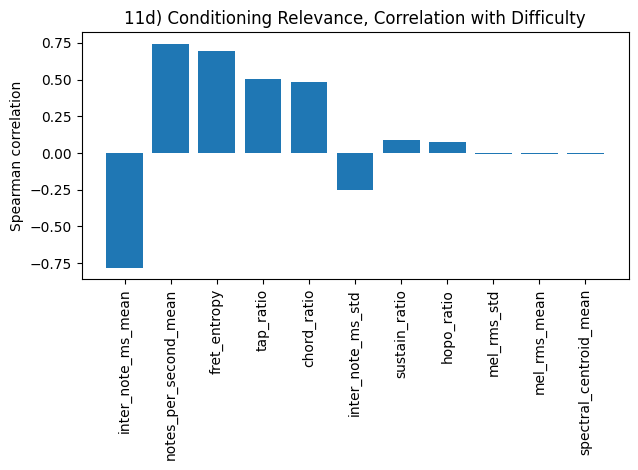

Conditioning relevance ranking
               feature  spearman_vs_difficulty  abs_corr
    inter_note_ms_mean               -0.781675  0.781675
 notes_per_second_mean                0.745203  0.745203
          fret_entropy                0.697761  0.697761
             tap_ratio                0.506403  0.506403
           chord_ratio                0.483076  0.483076
     inter_note_ms_std               -0.253697  0.253697
         sustain_ratio                0.086214  0.086214
            hopo_ratio                0.072779  0.072779
           mel_rms_std               -0.006034  0.006034
          mel_rms_mean               -0.005936  0.005936
spectral_centroid_mean               -0.003955  0.003955
             tempo_bpm                     NaN       NaN


In [38]:
rows = []
for col in use_cols:
    sub = df_features[["difficulty_id", col]].dropna()
    if len(sub) < 200:
        continue
    r, _ = spearmanr(sub["difficulty_id"], sub[col])
    rows.append({
        "feature": col,
        "spearman_vs_difficulty": r
    })

rel = (
    pd.DataFrame(rows)
    .assign(abs_corr=lambda d: d["spearman_vs_difficulty"].abs())
    .sort_values("abs_corr", ascending=False)
)

plt.bar(rel["feature"], rel["spearman_vs_difficulty"])
plt.xticks(rotation=90)
plt.ylabel("Spearman correlation")
plt.title("11d) Conditioning Relevance, Correlation with Difficulty")
plt.tight_layout()
plt.show()

print("Conditioning relevance ranking")
print(rel.to_string(index=False))


Difficulty is most strongly associated with note spacing and density, with inter note mean having a large negative correlation and notes per second having a large positive correlation. Fret entropy also correlates strongly with difficulty, indicating harder charts use a wider spread of frets. Tap ratio and chord ratio show moderate positive correlations, suggesting advanced mechanics and chord usage increase with difficulty but are secondary to raw speed and complexity. Inter note variability has a weaker negative relationship, while sustain and HOPO ratios have only small positive correlations. Audio features show near zero correlation with difficulty, and tempo is missing or constant, so it provides no usable difficulty signal.

<h1>12. Genre Structure and Clustering Analysis</h1>

difficulty_id,0,1,2,3
genre_id,,,,
0,4,4,4,7
1,6027,6018,6015,6265
2,2680,2680,2686,3026
3,1302,1302,1302,1346
4,815,813,813,839
5,404,404,404,447
6,4,4,4,13
7,714,714,714,718
8,301,301,301,302


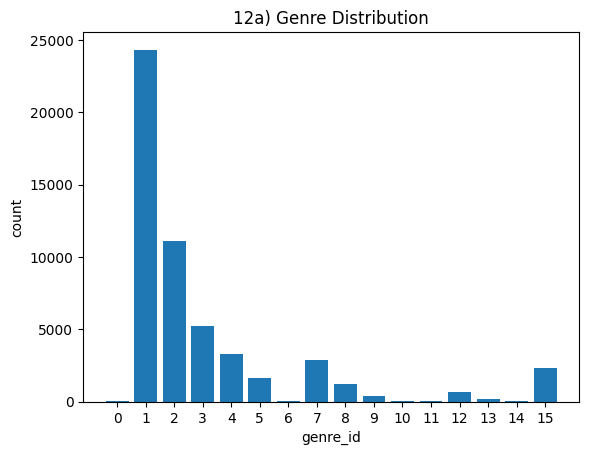

In [39]:
ct = pd.crosstab(df_features["genre_id"], df_features["difficulty_id"])
display(ct)

genre_counts = df_features["genre_id"].value_counts().sort_index()

plt.bar(genre_counts.index.astype(str), genre_counts.values)
plt.xlabel("genre_id")
plt.ylabel("count")
plt.title("12a) Genre Distribution")
plt.show()


The dataset is heavily imbalanced by genre, with genre 1 dominating by a large margin, followed by genres 2 and 3, while many other genres have very few samples. The distribution across difficulties is fairly consistent within each genre, meaning each major genre is represented at all difficulty levels in roughly similar proportions. However, the long tail of low count genres could bias modeling and evaluation toward the dominant genres, suggesting that weighting, stratified sampling, or genre conditioning may be necessary for balanced tab generation.


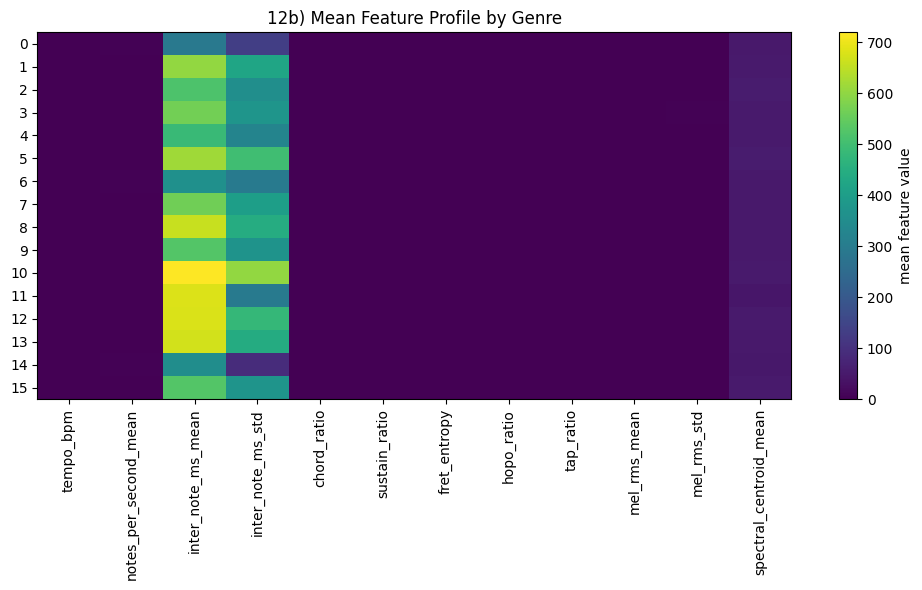

In [40]:
genre_means = (
    df_features
    .groupby("genre_id")[use_cols]
    .mean()
)

plt.figure(figsize=(10, 6))
plt.imshow(genre_means.values, aspect="auto")
plt.xticks(range(len(use_cols)), use_cols, rotation=90)
plt.yticks(range(len(genre_means.index)), genre_means.index)
plt.colorbar(label="mean feature value")
plt.title("12b) Mean Feature Profile by Genre")
plt.tight_layout()
plt.show()


Genre level averages show meaningful structural differences across styles. Note density and inter note timing vary substantially by genre, indicating some genres are consistently faster and more tightly spaced than others. Inter note variability also differs, suggesting different rhythmic consistency patterns across genres. In contrast, most mechanical ratios such as chord, sustain, HOPO, and tap show relatively smaller variation at the genre mean level compared to timing features. Audio features, particularly spectral centroid and mel RMS, also vary by genre, reflecting tonal differences, but they do not dominate gameplay structure. This indicates that genre primarily influences speed and rhythmic spacing, while mechanic usage varies more within genre than across genres, suggesting genre is a strong conditioning variable for pacing but a weaker one for detailed mechanic composition.

C:\Users\Susan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\Susan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


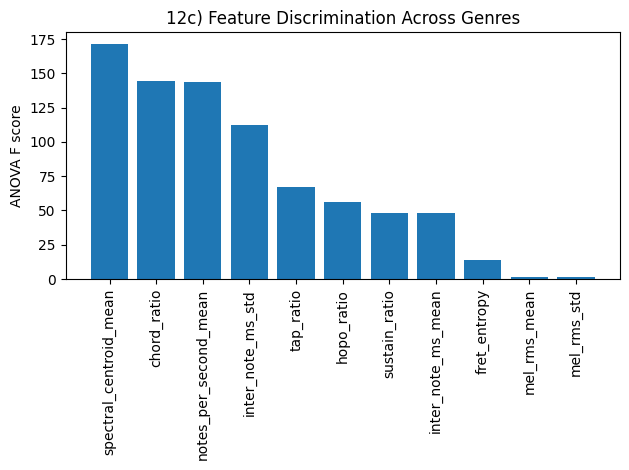

                   feature     F_score
11  spectral_centroid_mean  171.421199
4              chord_ratio  144.498349
1    notes_per_second_mean  143.893252
3        inter_note_ms_std  112.106677
8                tap_ratio   66.849835
7               hopo_ratio   55.953749
5            sustain_ratio   48.095975
2       inter_note_ms_mean   47.821669
6             fret_entropy   14.235510
9             mel_rms_mean    1.377442
10             mel_rms_std    1.353405
0                tempo_bpm         NaN


In [41]:
X = clean_df(df_features, use_cols)
y = df_features.loc[X.index, "genre_id"]

f_vals, p_vals = f_classif(X, y)

anova_df = pd.DataFrame({
    "feature": use_cols,
    "F_score": f_vals,
}).sort_values("F_score", ascending=False)

plt.bar(anova_df["feature"], anova_df["F_score"])
plt.xticks(rotation=90)
plt.ylabel("ANOVA F score")
plt.title("12c) Feature Discrimination Across Genres")
plt.tight_layout()
plt.show()

print(anova_df)


Genre differences are most strongly captured by spectral centroid, making tonal brightness the top distinguishing feature. Gameplay features also show meaningful genre separation, especially chord ratio and note density, followed by inter note variability and tap usage. Sustain and HOPO ratios contribute moderately, while fret entropy has limited discriminatory power. Audio energy features such as mel RMS mean and standard deviation do not contribute in any meaningful way.

In [42]:
X = clean_df(df_features, use_cols)
y = df_features.loc[X.index, "genre_id"]

scaled = standardize(X)
k = len(np.unique(y))
labels = kmeans_labels(scaled, k)

ari = adjusted_rand_score(y, labels)
sil = silhouette_score(scaled, labels)

print("12d) Clustering vs Genre")
print("Adjusted Rand Index:", ari)
print("Silhouette score:", sil)


12d) Clustering vs Genre
Adjusted Rand Index: 0.008500950559756085
Silhouette score: 0.18563547683992332


Clustering structure does not align with genre. The Adjusted Rand Index is essentially zero, indicating almost no agreement between KMeans clusters and genre labels. The silhouette score is modest, meaning clusters exist in feature space, but they do not correspond to genre boundaries.

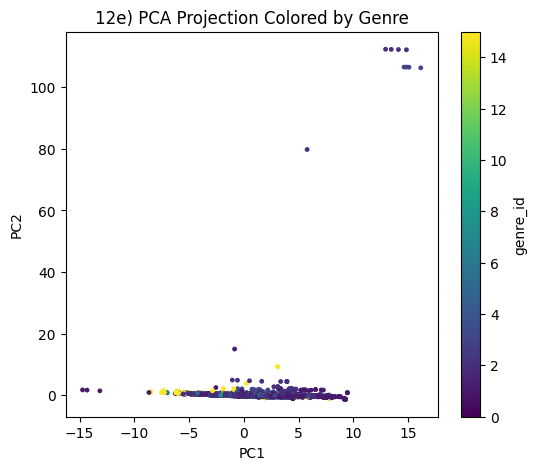

In [43]:
Z = pca2(scaled, n_components=2, random_state=0)

plt.figure(figsize=(6, 5))
plt.scatter(Z[:, 0], Z[:, 1], c=y, s=6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("12e) PCA Projection Colored by Genre")
plt.colorbar(label="genre_id")
plt.show()


The PCA projection shows heavy overlap between genres in the main structural feature space. Most genres cluster in the same dense region along PC1 and PC2, with no clear genre separated boundaries. A few outliers appear at extreme PC2 values, but they are sparse and do not form distinct genre clusters. Overall, the genre does not form clean separable groups in the primary gameplay feature dimensions, reinforcing that structural chart style is largely independent of musical genre.